In [326]:
%reset -f

In [327]:
from sklearn.metrics import precision_recall_fscore_support,classification_report
from sklearn import svm, datasets, feature_selection, cross_validation
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.cross_validation import cross_val_score, train_test_split
from sklearn.grid_search import GridSearchCV, ParameterGrid
from sklearn.preprocessing import StandardScaler, normalize, Normalizer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, mutual_info_score, normalized_mutual_info_score
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import validation_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV,chi2, f_oneway
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn import feature_selection
from sklearn import cross_validation
from sklearn.externals import joblib
from sklearn import cross_validation
from sklearn import preprocessing
from multiprocessing import Pool
from sklearn.svm import SVC

from IPython.display import display, HTML
import logging.config
import pandas as pd
import numpy as np 
import datetime
import csv
import os
import pickle
import sys

sys.path.insert(1, "/home/aegle/projects/myosa/src/")
from TypeFeatImputer import TypeFeatImputer
from i_score_parallel import i_score

from pylab import *
import seaborn as sns
import matplotlib.pyplot as plt


np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('classic')

%matplotlib inline

### 1.Load train & test data

In [328]:
datafilenames = []
datafilenames.append(os.path.join('resources','data_filtered_cl0_short_no_monit_14012016_final.pkl'))
datafilenames.append(os.path.join('resources','data_filtered_cl0_short_1m_monit_14012016_final.pkl'))
datafilenames.append(os.path.join('resources','data_filtered_cl0_short_3m_1m_monit_14012016.pkl'))

datafilenames1 = []
datafilenames1.append(os.path.join('resources','mapping_filtered_cl0_short_no_monit_14012016_final.pkl'))
datafilenames1.append(os.path.join('resources','mapping_filtered_cl0_short_1m_monit_14012016_final.pkl'))
datafilenames1.append(os.path.join('resources','mapping_filtered_cl0_short_3m_1m_monit_14012016.pkl'))

index = 2

In [329]:
#Load mapping features of M1
f = file(datafilenames1[1],"rb")
dfFeatures1 = pd.read_pickle(f)
f.close()

#Load filtered dataset M_1:
f = file(datafilenames[1],"rb")
df0 = pd.read_pickle(f)
f.close()

codes = df0.iloc[:,0]
df0 = df0.iloc[:,1:]
dfLabel = df0["LABEL"]
df0 = df0[[c for c in df0.columns if c != "LABEL"]]
columns= df0.columns
ft0 = dict([(c,df0[c].dtype.name) for c in df0.columns])

print columns
print len(columns), len(codes)
print df0.shape
print len(ft0),ft0

#Load dataset Month-3:
f = file(datafilenames[2],"rb")
df1 = pd.read_pickle(f)
f.close()

col1 = [c for c in df1.columns if "_3" in c]
df1 = df1[col1]
ft1 = dict([(c,df1[c].dtype.name) for c in df1.columns])

print len(col1)
print df1.shape
print ft1

#Merge Month_1 + Month_3 features data
df_all = pd.concat([df0,df1], axis=1)
df_all["LABEL"] = dfLabel
columns = df_all.columns

feat_types = dict([])
feat_types.update(ft0)
feat_types.update(ft1)
feat_types.update({"LABEL":"int64"})

print df_all.shape
print len(feat_types)
print len(columns)
print columns

Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL',
       u'TOTAL_USE_HOURS_1', u'MEAN_USE_HOURS_1', u'AL_IRR_CUT_MASC_1',
       u'DRY_MOUTH_1', u'TAS_MEAN_1', u'TAD_MEAN_1', u'EPWORTH_1',
       u'EUROQOL_1', u'VISUAL_EUROQOL_1'],
     

In [330]:
mapCols = dict()
mapCols["HORAS_USO_TOT_3"] = ["TOTAL_USE_HOURS_3", "Total hours of use","","NUM", "CPAP_DEVICE", "M3"]

mapCols["HORAS_USO_MED_NOCHE_3"] = ["MEAN_USE_HOURS_3", "Mean hours of use nightly","", "NUM", "CPAP_DEVICE", "M3"]
mapCols["ABANDONO_3"] = ["ABANDON_3", "Abandon","'no':0, 'yes':1", "CAT", "SYMPTOMS", "M3"]
mapCols["AL_IRR_CUT_MAS_3"] = ["AL_IRR_CUT_MASC_3", "Allergies/Cutaneous Irritation caused by the use of the mask","'no':0, 'yes':1", "CAT", "SYMPTOMS", "M3"]

mapCols["BOCA_SECA_3"] = ["DRY_MOUTH_3","Dry mouth", "'no':0, 'yes':1","CAT","SYMPTOMS", "M3"]
mapCols["CONG_NASAL_3"] = ["CONG_NASAL_3","Nasal congestion", "'no':0, 'yes':1","CAT","SYMPTOMS", "M3"]
mapCols["SECR_NASAL_3"] = ["RUNNY_NOSE_3","Runny nasal", "'no':0, 'yes':1","CAT","SYMPTOMS", "M3"]
mapCols["ESTORNUDOS_3"] = ["SNEEZING_3","Sneezing", "'no':0, 'yes':1", "CAT", "SYMPTOMS","M3"]

mapCols["SINUSITIS_3"] = ["SINUSITIS_3","Sinusitis", "'no':0, 'yes':1","CAT","SYMPTOMS", "M3"]
mapCols["HEMO_NASAL_3"] = ["NOSEBLEED_3", "Nosebleed","'no':0, 'yes':1", "CAT","SYMPTOMS", "M3"]
mapCols["MALESTAR_3"] = ["DISCOMFORT_3","Discomfort", "'no':0, 'yes':1","CAT","SYMPTOMS", "M3"]
mapCols["MEDIA TAS_3"] = ["TAS_MEAN_3","Systolic blood pressure", "", "NUM", "VISIT_3","M3"]

mapCols["MEDIA TAD_3"] = ["TAD_MEAN_3","Diastolic blood pressure", "","NUM","VISIT_3", "M3"]
mapCols["PESO_3"] = ["WEIGHT_3","Diastolic blood pressure", "","NUM","VISIT_3", "M3"]
mapCols["TALLA_3"] = ["SIZE_3","Diastolic blood pressure", "","NUM","VISIT_3", "M3"]
mapCols["IMC_3"] = ["BMI_3","Diastolic blood pressure", "","NUM","VISIT_3", "M3"]
mapCols["FARMACOS ANADIDOS_3"] = ["ADDED_DRUGS_3","Whether drugs were added to the patient prescription", "'no':0, 'yes':1","CAT","VISIT_3", "M3"]

mapCols["FARMACOS QUITADOS_3"] = ["REMOVED_DRUGS_3","Whether drugs were removed from the patient prescription", "'no':0, 'yes':1","CAT","VISIT_3", "M3"]
mapCols["EPWORTH_3"] = ["EPWORTH_3", "Questionnaire result of daytime sleepiness","[0-24]", "NUM","VISIT_3", "M3"]
mapCols["EUROQOL_3"] = ["EUROQOL_3","Questionnaire result for measuring generic health status", "[0-1]","NUM","VISIT_3", "M3"]
mapCols["VISUAL EUROQOL_3"] = ["VISUAL_EUROQOL_3", "Visual Analog Scale (VAS)","[0-100]", "NUM","VISIT_3", "M3"]

pd.set_option("max_r",120)
pd.set_option('display.max_colwidth', -1)


dfFeatures3 = pd.DataFrame(mapCols.values(), columns=["Name","Description","Values","Type","Cat","Month"], index=mapCols.keys())
dfFeatures = pd.concat([dfFeatures1, dfFeatures3])

print dfFeatures.shape
print dfFeatures1.shape
print dfFeatures3.shape

for cat in dfFeatures3.Cat.unique():
    display(HTML(dfFeatures3[dfFeatures3.Cat == cat].sort_values(["Month","Cat","Name"]).to_html(index=False)))

(114, 6)
(93, 6)
(21, 6)


Name,Description,Values,Type,Cat,Month
ABANDON_3,Abandon,"'no':0, 'yes':1",CAT,SYMPTOMS,M3
AL_IRR_CUT_MASC_3,Allergies/Cutaneous Irritation caused by the use of the mask,"'no':0, 'yes':1",CAT,SYMPTOMS,M3
CONG_NASAL_3,Nasal congestion,"'no':0, 'yes':1",CAT,SYMPTOMS,M3
DISCOMFORT_3,Discomfort,"'no':0, 'yes':1",CAT,SYMPTOMS,M3
DRY_MOUTH_3,Dry mouth,"'no':0, 'yes':1",CAT,SYMPTOMS,M3
NOSEBLEED_3,Nosebleed,"'no':0, 'yes':1",CAT,SYMPTOMS,M3
RUNNY_NOSE_3,Runny nasal,"'no':0, 'yes':1",CAT,SYMPTOMS,M3
SINUSITIS_3,Sinusitis,"'no':0, 'yes':1",CAT,SYMPTOMS,M3
SNEEZING_3,Sneezing,"'no':0, 'yes':1",CAT,SYMPTOMS,M3


Name,Description,Values,Type,Cat,Month
ADDED_DRUGS_3,Whether drugs were added to the patient prescription,"'no':0, 'yes':1",CAT,VISIT_3,M3
BMI_3,Diastolic blood pressure,,NUM,VISIT_3,M3
EPWORTH_3,Questionnaire result of daytime sleepiness,[0-24],NUM,VISIT_3,M3
EUROQOL_3,Questionnaire result for measuring generic health status,[0-1],NUM,VISIT_3,M3
REMOVED_DRUGS_3,Whether drugs were removed from the patient prescription,"'no':0, 'yes':1",CAT,VISIT_3,M3
SIZE_3,Diastolic blood pressure,,NUM,VISIT_3,M3
TAD_MEAN_3,Diastolic blood pressure,,NUM,VISIT_3,M3
TAS_MEAN_3,Systolic blood pressure,,NUM,VISIT_3,M3
VISUAL_EUROQOL_3,Visual Analog Scale (VAS),[0-100],NUM,VISIT_3,M3
WEIGHT_3,Diastolic blood pressure,,NUM,VISIT_3,M3


Name,Description,Values,Type,Cat,Month
MEAN_USE_HOURS_3,Mean hours of use nightly,,NUM,CPAP_DEVICE,M3
TOTAL_USE_HOURS_3,Total hours of use,,NUM,CPAP_DEVICE,M3


In [331]:
print df_all.columns

new_cols = []
for c in columns:
    if c in dfFeatures.index.tolist():
        c = dfFeatures.ix[c].Name
    new_cols.append(c)

df_all.columns = new_cols
columns= df_all.columns
feat_types = dict([(c,df_all[c].dtype.name) for c in df_all.columns])

print df_all.columns
print df_all.shape

Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL',
       u'TOTAL_USE_HOURS_1', u'MEAN_USE_HOURS_1', u'AL_IRR_CUT_MASC_1',
       u'DRY_MOUTH_1', u'TAS_MEAN_1', u'TAD_MEAN_1', u'EPWORTH_1',
       u'EUROQOL_1', u'VISUAL_EUROQOL_1', u'HORA

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


### 2. ALL data exploration & visualization

#### Column types

In [332]:
catCols = []
reducedCols = columns[:-1]

CAT_ES = ["RONCA","SUE_REP","CRISIS_ASF","NICTURIA","APNEAS_PRES","CEFALEA",
                "SOMN_DIURN","DESPERTAR_NOCT","TRAST_MEM","TRAST_CONC","IRR_APAT_DEPR"]
CAT_EN = dfFeatures.ix[CAT_ES].Name.tolist()
print CAT_EN

for i in range(len(columns)-1):

    if feat_types[columns[i]] == 'object' or columns[i] in CAT_EN:
        catCols.append(1)
    else:
        catCols.append(0)
        
catCols = np.array(catCols)

print len(catCols)
print "\nCat cols:", np.sum(catCols==1)
print "*************"
print columns[:-1][catCols==1]

print "\nNum cols:", np.sum(catCols==0)
print "*************"
print columns[:-1][catCols==0]

print len(reducedCols), type(reducedCols)

['SNORES', 'REP_SLEEP', 'CRISIS_ASP', 'NOCTURIA', 'APNEAS_PRES', 'CEFALEA', 'DAY_SOMN', 'AWAKE_NIGHT', 'MEM_DIS', 'CONC_DIS', 'IRR_APAT_DEPRE']
84

Cat cols: 48
*************
Index([u'GENDER', u'ACTIVE', u'RETIRED', u'SMOKER', u'ALCOHOL', u'DEPRESSION',
       u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS', u'DIABETES',
       u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'AL_IRR_CUT_MASC_1', u'DRY_MOUTH_1',
       u'ABANDON_3', u'AL_IRR_CUT_MASC_3', u'DRY_MOUTH_3', u'CONG_NASAL_3',
       u'RUNNY_NOSE_3', u'SNEEZING_3', u'SINUSITIS_3', u'NOSEBLEED_3',
       u'DISCOMFORT_3', u'ADDED_DRUGS_3', u'REMOVED_DRUGS_3'],
      dtype='object')

Num cols: 36


#### Cohort description

In [333]:
catData = []
for i in range(dfFeatures3.shape[0]):

    if dfFeatures3.iloc[i].Type == "CAT":
        rv = dfFeatures3.iloc[i]["Name"]
        cleanIc = df_all[rv]
        catData.append([rv,
                        np.sum(cleanIc.isnull() == False),
                        np.sum(cleanIc.isnull()) / float(len(cleanIc)),
                        pd.value_counts(cleanIc).index.astype(int).tolist(), 
                        pd.value_counts(cleanIc).values.tolist(),
                        (pd.value_counts(cleanIc).values/float(np.sum(pd.value_counts(cleanIc).values))).round(2).tolist(),
                        pd.value_counts(cleanIc).values.min(),
                        pd.value_counts(cleanIc).values.max(),
                        dfFeatures3[dfFeatures3["Name"] == rv]["Cat"].values[0]
                        ])
    
dfCatData = pd.DataFrame(catData, columns=["variable","n",u"%nulls","values","frequencies","ratios","min","max", "type"])

print dfCatData.shape[0]
display(HTML(dfCatData.to_html(index=False)))

11


variable,n,%nulls,values,frequencies,ratios,min,max,type
SNEEZING_3,40,0.05,[0],[40],[1.0],40,40,SYMPTOMS
ABANDON_3,40,0.05,"[0, 1]","[39, 1]","[0.98, 0.02]",1,39,SYMPTOMS
SINUSITIS_3,40,0.05,[0],[40],[1.0],40,40,SYMPTOMS
DRY_MOUTH_3,40,0.05,"[0, 1]","[31, 9]","[0.78, 0.22]",9,31,SYMPTOMS
NOSEBLEED_3,40,0.05,[0],[40],[1.0],40,40,SYMPTOMS
AL_IRR_CUT_MASC_3,40,0.05,"[0, 1]","[39, 1]","[0.98, 0.02]",1,39,SYMPTOMS
REMOVED_DRUGS_3,40,0.05,"[0, 1]","[37, 3]","[0.92, 0.08]",3,37,VISIT_3
ADDED_DRUGS_3,40,0.05,"[0, 1]","[37, 3]","[0.92, 0.08]",3,37,VISIT_3
RUNNY_NOSE_3,40,0.05,[0],[40],[1.0],40,40,SYMPTOMS
DISCOMFORT_3,40,0.05,"[0, 1]","[39, 1]","[0.98, 0.02]",1,39,SYMPTOMS


In [334]:
numData = df_all[dfFeatures3[dfFeatures3.Type == "NUM"].Name.values].describe().T.copy()

numData["n"] = numData["count"].astype(int)
numData["variable"] = numData.index.values
numData["#nulls"] = 42 - numData["n"]
numData["%nulls"] = numData["#nulls"] / 42.0

types = []
for v in numData["variable"].values:
    types.append(dfFeatures[dfFeatures["Name"] == v]["Cat"])

numData["type"] = np.array(types)

print numData.shape[0]
display(HTML(numData
             [["variable","n",u"%nulls","mean","std","min","25%","50%","75%","max","type"]].to_html(index=False)))

10


variable,n,%nulls,mean,std,min,25%,50%,75%,max,type
SIZE_3,40,0.05,1.68,0.10,1.50,1.60,1.67,1.73,1.92,VISIT_3
TAS_MEAN_3,38,0.10,133.88,19.57,96.50,118.25,136.50,145.50,170.00,VISIT_3
EUROQOL_3,39,0.07,0.84,0.20,0.22,0.74,0.80,1.00,1.00,VISIT_3
MEAN_USE_HOURS_3,40,0.05,5.33,1.90,0.60,4.38,5.50,7.00,8.50,CPAP_DEVICE
TOTAL_USE_HOURS_3,40,0.05,479.14,181.36,59.00,378.00,483.50,633.50,812.00,CPAP_DEVICE
EPWORTH_3,40,0.05,5.88,3.86,1.00,3.40,5.50,7.00,20.00,VISIT_3
VISUAL_EUROQOL_3,39,0.07,71.69,20.13,0.85,70.00,80.00,80.00,100.00,VISIT_3
BMI_3,40,0.05,34.12,6.65,23.87,29.37,34.08,37.78,52.44,VISIT_3
TAD_MEAN_3,39,0.07,81.28,14.37,40.35,74.50,83.00,88.00,109.00,VISIT_3
WEIGHT_3,40,0.05,95.13,16.53,65.00,81.95,95.00,108.70,132.70,VISIT_3


#### Null values

,%_Null,#_Null
SNEEZING_3,0.05,2
ABANDON_3,0.05,2
SIZE_3,0.05,2
SINUSITIS_3,0.05,2
DRY_MOUTH_3,0.05,2
NOSEBLEED_3,0.05,2
AL_IRR_CUT_MASC_3,0.05,2
REMOVED_DRUGS_3,0.05,2
TAS_MEAN_3,0.10,4
EUROQOL_3,0.07,3


21
21


<function matplotlib.pyplot.show>

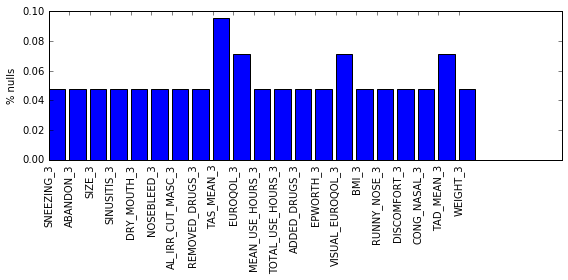

In [335]:
dfNull = np.sum(df_all[dfFeatures3.Name.values].isnull()) / float(df_all.shape[0])

dfNullAll = pd.concat([dfNull, np.sum(df_all[dfFeatures3.Name.values].isnull())], axis=1)
dfNullAll.columns= ["%_Null","#_Null"]
                       
display(dfNullAll[["%_Null","#_Null"]])
print len(dfNullAll.iloc[:,0].tolist())
print dfNullAll.shape[0]

plt.figure(figsize=(8,4))
plt.bar(np.arange(dfNullAll.shape[0]), dfNullAll.iloc[:,0])
plt.xticks(np.arange(dfNullAll.shape[0]), dfNullAll.index,rotation=90)
plt.ylabel("% nulls")
plt.tight_layout()
plt.show

#### Impute NaN

In [336]:
df_all.loc[:,"EUROQOL_3"].values

array([ 1.     ,  0.7986 ,  0.73901,  0.7089 ,  1.     ,  1.     ,
        1.     ,  0.7902 ,  0.7986 ,  1.     ,  1.     ,  0.7005 ,
        1.     ,  1.     ,  1.     ,  1.     ,  0.7902 ,  0.7005 ,
        0.7601 ,  1.     ,  0.6493 ,  0.7902 ,  1.     ,  1.     ,
        1.     ,  0.7902 ,  1.     ,  1.     ,      nan,  0.7986 ,
        1.     ,      nan,  1.     ,  1.     ,  0.5442 ,  0.7601 ,
        0.5442 ,  0.73901,      nan,  0.2727 ,  0.217  ,  0.73901])

In [337]:
#Transform discrete
imputer = TypeFeatImputer(catCols, reducedCols)
imputer.fit(df_all.iloc[:,:-1].values.astype(float),df_all.iloc[:,-1].values.astype(float))

dfImputed = imputer.transform(df_all.iloc[:,:-1].values.astype(float))
dfImputed = pd.DataFrame(dfImputed,columns=df_all.columns[:-1])

print "Total NaN before imputation:", np.sum(np.isnan(df_all.values.astype(float)))
print "Total NaN after imputation:", np.sum(np.sum(np.isnan(dfImputed.astype(float))))
print df_all.columns[-1]
print df_all.iloc[:,-1].values

Total NaN before imputation: 95
Total NaN after imputation: 0
LABEL
[ 0.    6.5   5.    7.    5.    7.    4.    4.5   7.5   3.32  6.5   3.5
  6.51  6.5   6.    0.    8.    5.5   3.93  3.5   7.    4.99  7.5   4.    6.
  2.08  7.5   5.32  8.    7.    6.5   2.6   4.    4.5   0.97  5.5   7.    3.8
  2.12  7.5   4.    5.5 ]


#### Normality test

In [338]:
import scipy.stats as stats

arrNorm = []
for i,rv in enumerate(df_all[dfFeatures3.Name.values].columns):

    #Compute data
    cleanIc = dfImputed.loc[:,rv]    
    f_value, p_value = stats.normaltest(cleanIc)
    arrNorm.append([rv,"yes" if dfFeatures3[dfFeatures3.Name.values == rv].Type.values == "CAT" else "no", f_value.round(4), p_value.round(4), "no" if p_value < 0.05 else "yes"])
    
dfNorm = pd.DataFrame(np.array(arrNorm), columns=["variable","categoric","f_val","p_value","norm"])
print dfNorm.shape
print "Normal features:", np.sum(dfNorm["norm"] == "yes")
print "Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "no"))
print "Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "yes",dfNorm["categoric"] == "yes"))
print "No Normal features:", np.sum(dfNorm["norm"] == "no")
print "No Normal numerical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "no"))
print "No Normal categorical features:", np.sum(np.logical_and(dfNorm["norm"] == "no",dfNorm["categoric"] == "yes"))

dfNorm[dfNorm["categoric"] == "no"][["variable","f_val","p_value","norm"]]

(21, 5)
Normal features: 11
Normal numerical features: 6
Normal categorical features: 5
No Normal features: 10
No Normal numerical features: 4
No Normal categorical features: 6


,variable,f_val,p_value,norm
2,SIZE_3,0.3891,0.8232,yes
8,TAS_MEAN_3,0.7132,0.7001,yes
9,EUROQOL_3,17.291,0.0002,no
10,MEAN_USE_HOURS_3,4.3756,0.1122,yes
11,TOTAL_USE_HOURS_3,1.6353,0.4415,yes
13,EPWORTH_3,23.0853,0.0,no
14,VISUAL_EUROQOL_3,23.341,0.0,no
15,BMI_3,4.6122,0.0996,yes
19,TAD_MEAN_3,7.1724,0.0277,no
20,WEIGHT_3,0.6326,0.7288,yes


#### Distribution Numeric features

In [339]:
df_all.loc[:,"EUROQOL_1"].values.astype(float)

array([     nan,  0.7986 ,  0.73901,  0.7601 ,  1.     ,  1.     ,
        1.     ,  1.     ,  0.7986 ,  1.     ,  1.     ,  0.7005 ,
        1.     ,  1.     ,  1.     ,  1.     ,  0.7902 ,  1.     ,
        0.7601 ,  0.7601 ,  0.7986 ,  0.7986 ,      nan,  1.     ,
        0.7902 ,      nan,  1.     ,  0.7986 ,  0.493  ,  0.7986 ,
            nan,  0.7986 ,  0.7902 ,  0.7902 ,  1.     ,  0.7005 ,
        0.5442 ,  0.74301,  1.     ,  0.5942 ,      nan,  0.7902 ])

SIZE_3
Unique values: 27
p-value: 0.823200581832
Normal: True
Mean: 1.6785 std: 0.0927503048384


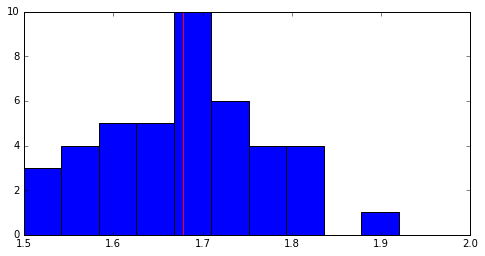

TAS_MEAN_3
Unique values: 33
p-value: 0.700068306867
Normal: True
Mean: 133.881578947 std: 18.3671012212


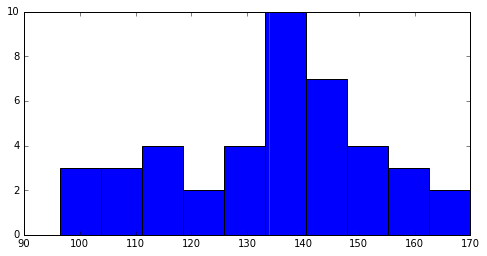

EUROQOL_3
Unique values: 12
p-value: 0.000175912464525
Normal: False
Mean: 0.836695641026 std: 0.190352363586


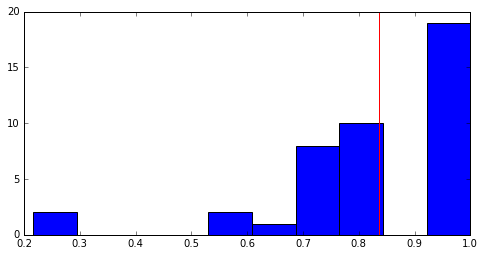

MEAN_USE_HOURS_3
Unique values: 22
p-value: 0.11216183929
Normal: True
Mean: 5.327 std: 1.82882501962


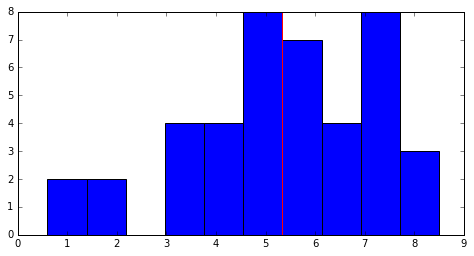

TOTAL_USE_HOURS_3
Unique values: 41
p-value: 0.441475830525
Normal: True
Mean: 479.145 std: 174.761746591


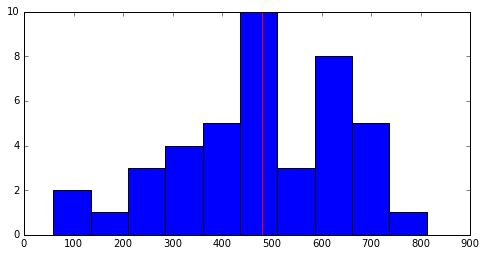

EPWORTH_3
Unique values: 14
p-value: 9.70721968732e-06
Normal: False
Mean: 5.88 std: 3.71837137928


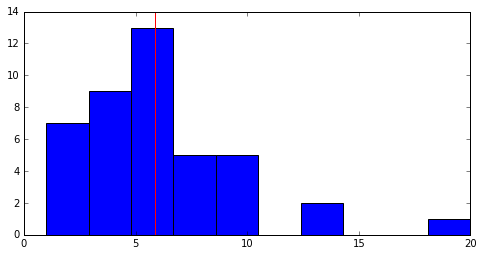

VISUAL_EUROQOL_3
Unique values: 11
p-value: 8.54193195793e-06
Normal: False
Mean: 71.6884615385 std: 19.1457674719


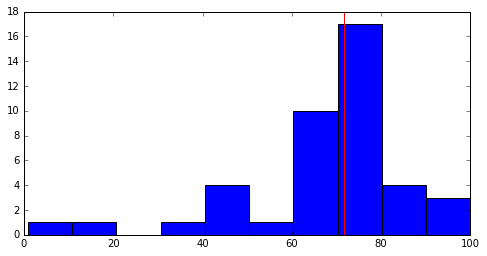

BMI_3
Unique values: 41
p-value: 0.099647158593
Normal: True
Mean: 34.1175 std: 6.40379342563


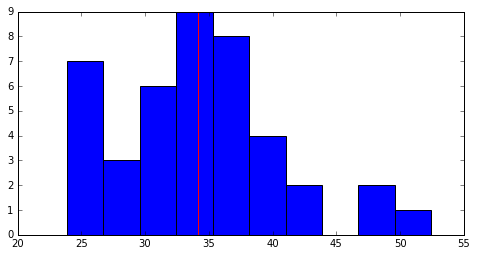

TAD_MEAN_3
Unique values: 31
p-value: 0.027702755921
Normal: False
Mean: 81.2782051282 std: 13.6727518169


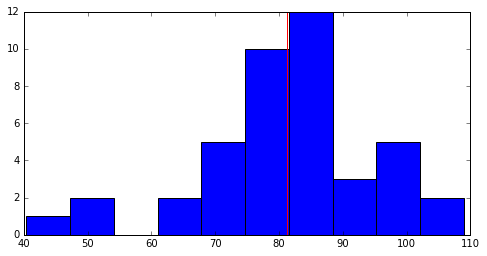

WEIGHT_3
Unique values: 37
p-value: 0.728826152183
Normal: True
Mean: 95.13 std: 15.9253048113


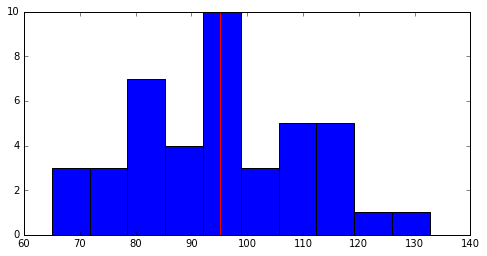

In [340]:
from scipy.stats import boxcox

for i,rv in enumerate(df_all[dfFeatures3.Name.values].columns):

    #Compute data
    cleanIc = dfImputed.loc[:,rv]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "no":

        f_value, p_value = stats.normaltest(cleanIc)
    
        print rv
        print "Unique values:", len(np.unique(cleanIc))
        print "p-value:", p_value 
        print "Normal:", p_value >= 0.05
        print "Mean:", np.mean(cleanIc), "std:", np.std(cleanIc)
        
        plt.figure(figsize=(8,4))
        plt.hist(cleanIc, bins=10)
        plt.axvline(np.mean(cleanIc), c="r")
        plt.show()        

#### Distribution categorical features

SNEEZING_3
0.00    42
Name: SNEEZING_3, dtype: int64


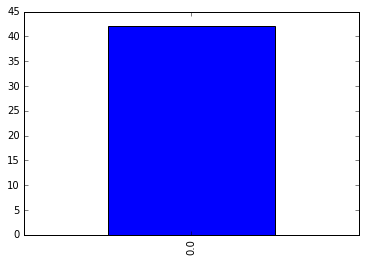

ABANDON_3
0.00    41
1.00    1 
Name: ABANDON_3, dtype: int64


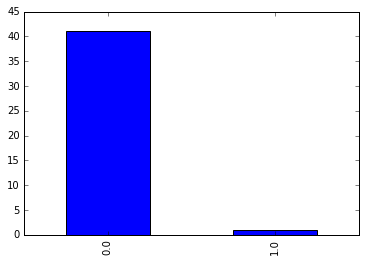

SINUSITIS_3
0.00    42
Name: SINUSITIS_3, dtype: int64


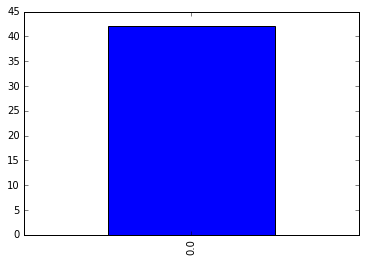

DRY_MOUTH_3
0.00    33
1.00    9 
Name: DRY_MOUTH_3, dtype: int64


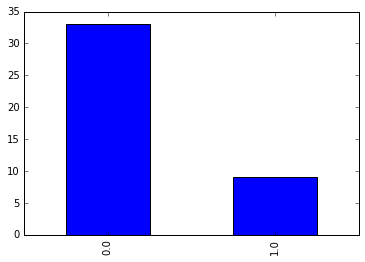

NOSEBLEED_3
0.00    42
Name: NOSEBLEED_3, dtype: int64


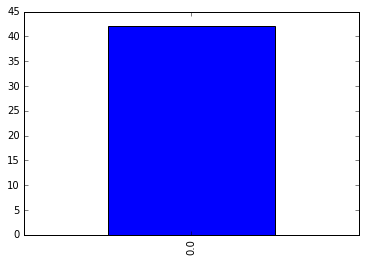

AL_IRR_CUT_MASC_3
0.00    41
1.00    1 
Name: AL_IRR_CUT_MASC_3, dtype: int64


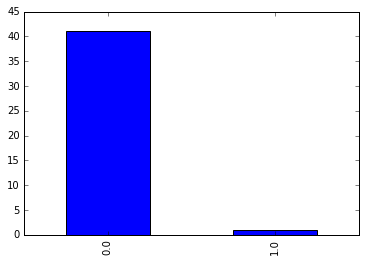

REMOVED_DRUGS_3
0.00    39
1.00    3 
Name: REMOVED_DRUGS_3, dtype: int64


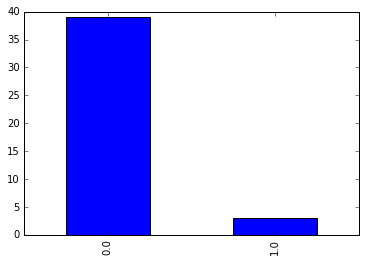

ADDED_DRUGS_3
0.00    39
1.00    3 
Name: ADDED_DRUGS_3, dtype: int64


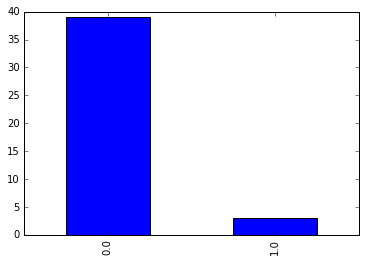

RUNNY_NOSE_3
0.00    42
Name: RUNNY_NOSE_3, dtype: int64


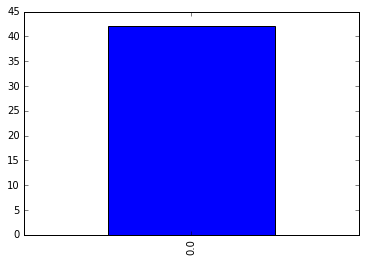

DISCOMFORT_3
0.00    41
1.00    1 
Name: DISCOMFORT_3, dtype: int64


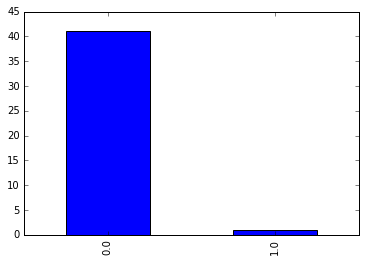

CONG_NASAL_3
0.00    42
Name: CONG_NASAL_3, dtype: int64


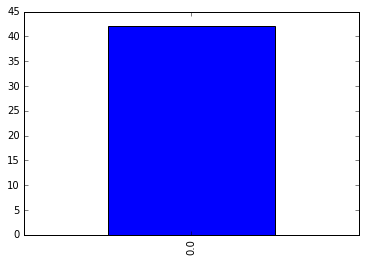

In [341]:
for i,rv in enumerate(df_all[dfFeatures3.Name.values].columns):
    
    #Compute data
    cleanIc = dfImputed.loc[:,rv]
    
    if dfNorm[dfNorm.variable == rv][["categoric"]].values == "yes":                
        print rv
        print pd.value_counts(cleanIc)                
        pd.value_counts(cleanIc).plot(kind="bar")
        plt.show()

#### Irrelevant categorical features
(Few instances in a category)

In [342]:
minConts = []
for i,rv in enumerate(df_all[dfFeatures3.Name.values].columns):

    #Compute data
    cleanIc = dfImputed.loc[:,rv]
    
    if dfFeatures3[dfFeatures3.Name == rv][dfFeatures3.Type == "CAT"].shape[0] > 0:                
        minConts.append([rv,
                         pd.value_counts(cleanIc).index.tolist(), 
                         pd.value_counts(cleanIc).values.tolist(),
                         (pd.value_counts(cleanIc).values/float(np.sum(pd.value_counts(cleanIc).values))).round(2).tolist(),
                         pd.value_counts(cleanIc).values.min(),
                         pd.value_counts(cleanIc).values.max()
                        ])    
dfCatSum = pd.DataFrame(minConts, columns=["variable","categories","frequencies","ratios","min","max"])

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [343]:
to_del = dfFeatures.ix[["ABANDONO_3", "AL_IRR_CUT_MAS_3", "CONG_NASAL_3", "SECR_NASAL_3","ESTORNUDOS_3","SINUSITIS_3",
         "HEMO_NASAL_3","MALESTAR_3","FARMACOS ANADIDOS_3", "FARMACOS QUITADOS_3"]].Name.tolist()

display(HTML(dfCatSum[dfCatSum["variable"].isin(to_del)][["variable","categories","frequencies","ratios"]].to_html(index=False)))
print dfCatSum[dfCatSum["variable"].isin(to_del)].shape
print len(to_del)

variable,categories,frequencies,ratios
SNEEZING_3,[0.0],[42],[1.0]
ABANDON_3,"[0.0, 1.0]","[41, 1]","[0.98, 0.02]"
SINUSITIS_3,[0.0],[42],[1.0]
NOSEBLEED_3,[0.0],[42],[1.0]
AL_IRR_CUT_MASC_3,"[0.0, 1.0]","[41, 1]","[0.98, 0.02]"
REMOVED_DRUGS_3,"[0.0, 1.0]","[39, 3]","[0.93, 0.07]"
ADDED_DRUGS_3,"[0.0, 1.0]","[39, 3]","[0.93, 0.07]"
RUNNY_NOSE_3,[0.0],[42],[1.0]
DISCOMFORT_3,"[0.0, 1.0]","[41, 1]","[0.98, 0.02]"
CONG_NASAL_3,[0.0],[42],[1.0]


(10, 6)
10


#### Correlated numerical features

In [344]:
dfImputedLabel = pd.concat([dfImputed,df_all.iloc[:,-1]], axis=1)
print dfImputedLabel.shape

(42, 85)


In [345]:
#Correlations

relVars = df_all.columns[:-1][catCols==0]
relVars = [c for c in relVars.values if c not in to_del]

dataCor = []
for item in (relVars):
    for col in (relVars):

        cv1 = dfImputed[item].values
        cv2 = dfImputed[col].values
        
        #Spearman corr better for categorical features
        c_sp,p_sp = stats.spearmanr(cv1,cv2,nan_policy="raise")
        
        #Pearson corr, classical
        cv1_norm = np.log(cv1 + 1)#preprocessing.normalize(cv1.reshape(-1, 1))
        cv2_norm = np.log(cv2 + 1)#preprocessing.normalize(cv2.reshape(-1, 1))
        c_pr,p_pr = stats.pearsonr(cv1_norm,cv2_norm)
        
        #Normalized mutual info for non normal data
        c_mi = normalized_mutual_info_score(cv1, cv2)
        p_mi = -1
        
        sc1, pval1 = stats.mannwhitneyu(cv1.reshape(-1,1),df_all.iloc[:,-1].values.reshape(-1,1))
        sc2, pval2 = stats.mannwhitneyu(cv2.reshape(-1,1),df_all.iloc[:,-1].reshape(-1,1))
                
        
        dataCor.append([item,col,c_sp,p_sp,c_pr,p_pr,c_mi,p_mi, pval1, pval2])

dataCor = np.array(dataCor)
dfCorr = pd.DataFrame(dataCor,columns=["cov1","cov2","c_sp","p_sp","c_pr","p_pr","c_mi","p_mi","pval_cv1","pval_cv2"])
dfCorr["c_sp"] = dfCorr["c_sp"].astype(float)
dfCorr["c_pr"] = dfCorr["c_pr"].astype(float)
dfCorr["c_mi"] = dfCorr["c_mi"].astype(float)
dfCorr["pval_cv1"] = dfCorr["pval_cv1"].astype(float)
dfCorr["pval_cv2"] = dfCorr["pval_cv2"].astype(float)

print dfCorr.shape

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:26: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


(1296, 10)


In [346]:
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCorr[np.logical_and(dfCorr["c_sp"] >= 0.8, dfCorr["cov1"] != dfCorr["cov2"])][["cov1","cov2","c_sp"]].to_html(index=False)))

cov1,cov2,c_sp
SIZE,SIZE_3,0.945
BMI,BMI_3,0.892
MEAN_USE_HOURS_1,MEAN_USE_HOURS_3,0.815
TOTAL_USE_HOURS_3,MEAN_USE_HOURS_3,0.914
MEAN_USE_HOURS_3,MEAN_USE_HOURS_1,0.815
MEAN_USE_HOURS_3,TOTAL_USE_HOURS_3,0.914
SIZE_3,SIZE,0.945
BMI_3,BMI,0.892


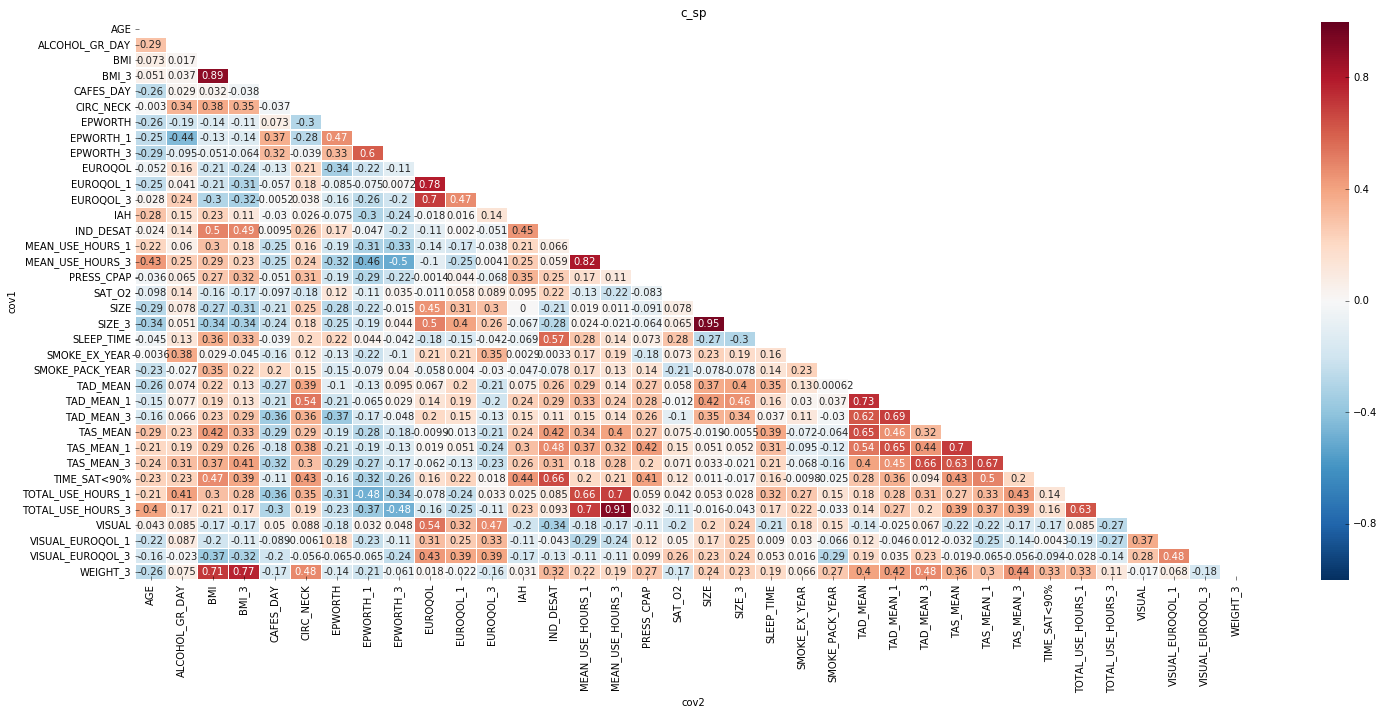

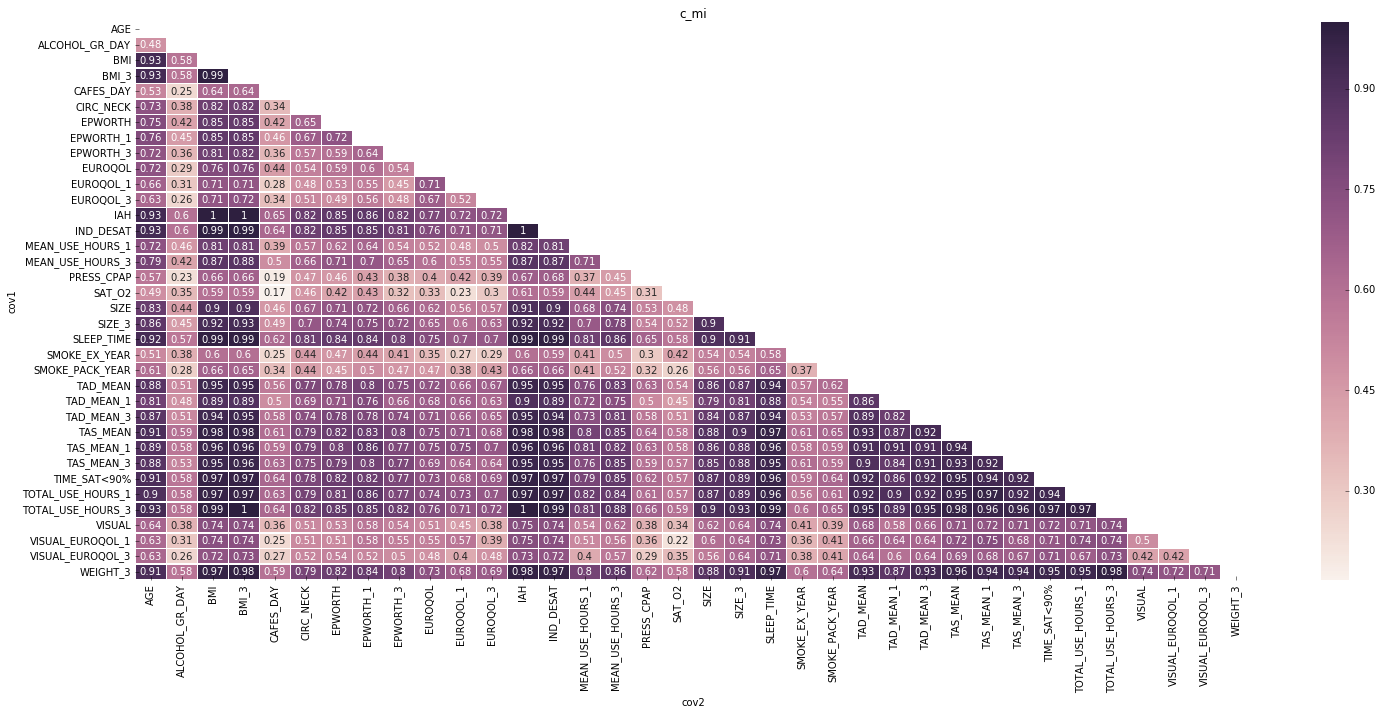

In [347]:
for c in ["c_sp","c_mi"]: #,"c_mi"
    pvt = dfCorr.pivot_table(index="cov1",columns="cov2", values=c)
    pvt

    # Generate a mask for the upper triangle
    mask = np.zeros_like(pvt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #Plot
    plt.figure(figsize=(25,10))
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    sns.heatmap(pvt.iloc[:,:], annot=True, linewidths=.5, mask=mask, fmt=".2g")
    
    plt.title(c)

#### Numerical features to remove

In [348]:
to_del.extend(dfFeatures.ix[["TALLA_3","HORAS_USO_TOT_3","IMC_3"]].Name.tolist())

print to_del

['ABANDON_3', 'AL_IRR_CUT_MASC_3', 'CONG_NASAL_3', 'RUNNY_NOSE_3', 'SNEEZING_3', 'SINUSITIS_3', 'NOSEBLEED_3', 'DISCOMFORT_3', 'ADDED_DRUGS_3', 'REMOVED_DRUGS_3', 'SIZE_3', 'TOTAL_USE_HOURS_3', 'BMI_3']


#### Correlations on categorical features

In [349]:
#Correlations

relVars = df_all.columns[:-1][catCols==1]
relVars = [c for c in relVars.values if c not in to_del]
dataCor = []
for item in (relVars):
    for col in (relVars):

        cv1 = dfImputed[item].values
        cv2 = dfImputed[col].values

        #Spearman corr better for categorical features
        c_sp,p_sp = stats.spearmanr(cv1,cv2,nan_policy="raise")

        #Pearson corr, classical
        c_pr,p_pr = stats.pearsonr(cv1,cv2)

        #Normalized mutual info for non normal data
        c_mi = normalized_mutual_info_score(cv1, cv2)
        p_mi = -1
        dataCor.append([item,col,c_sp,p_sp,c_pr,p_pr,c_mi,p_mi])

dataCor = np.array(dataCor)
dfCorr = pd.DataFrame(dataCor,columns=["cov1","cov2","c_sp","p_sp","c_pr","p_pr","c_mi","p_mi"])
dfCorr["c_sp"] = dfCorr["c_sp"].astype(float)
dfCorr["c_pr"] = dfCorr["c_pr"].astype(float)
dfCorr["c_mi"] = dfCorr["c_mi"].astype(float)
print dfCorr.shape

(1444, 8)


In [350]:
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCorr[np.logical_and(dfCorr["c_mi"] >= 0.5, dfCorr["cov1"] != dfCorr["cov2"])][["cov1","cov2","c_mi"]].to_html(index=False)))

cov1,cov2,c_mi
ACTIVE,RETIRED,0.683
RETIRED,ACTIVE,0.683


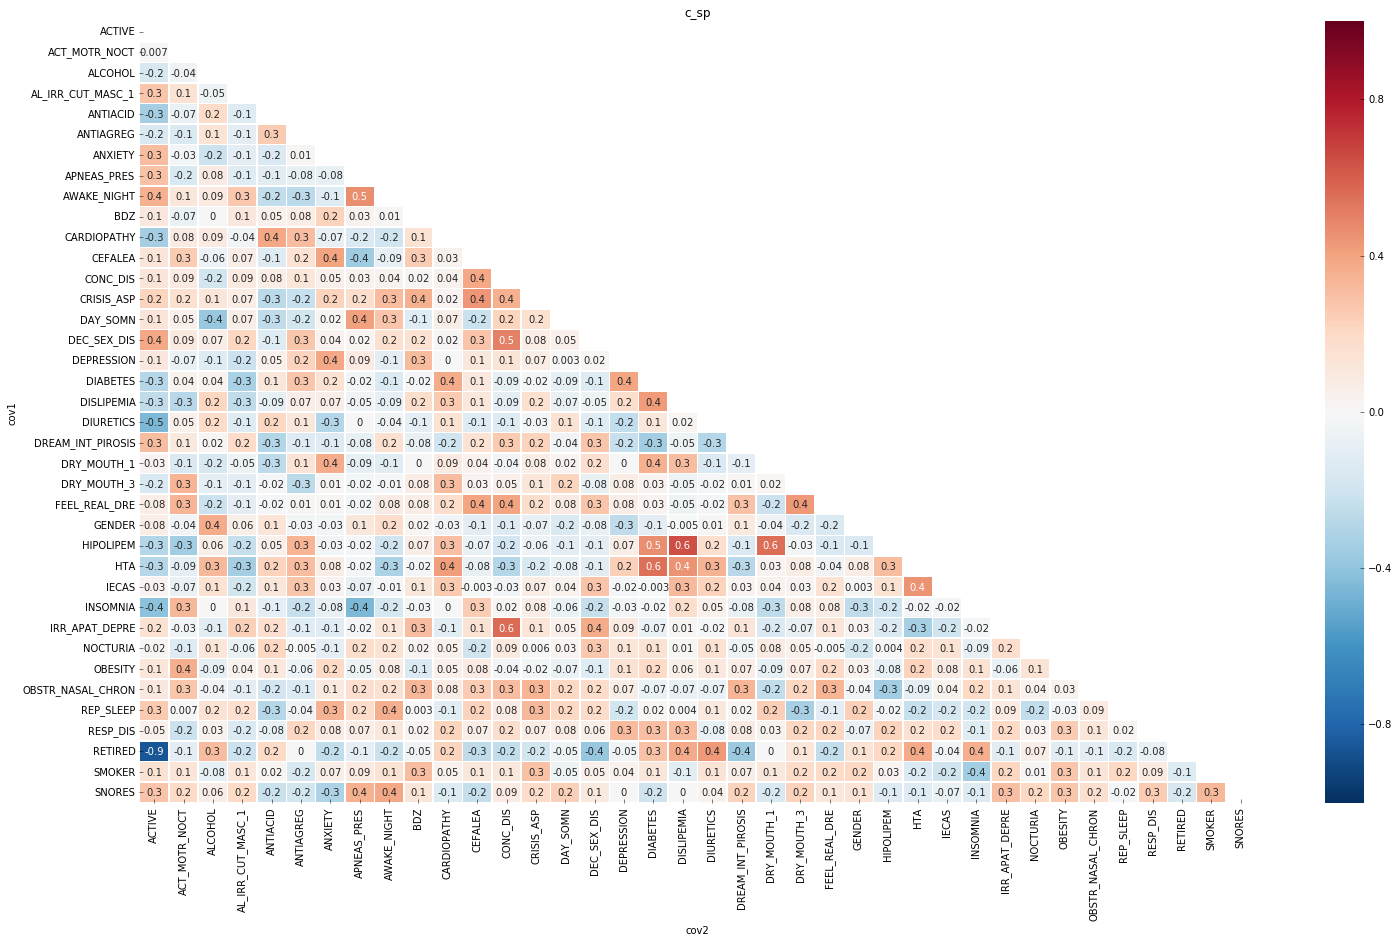

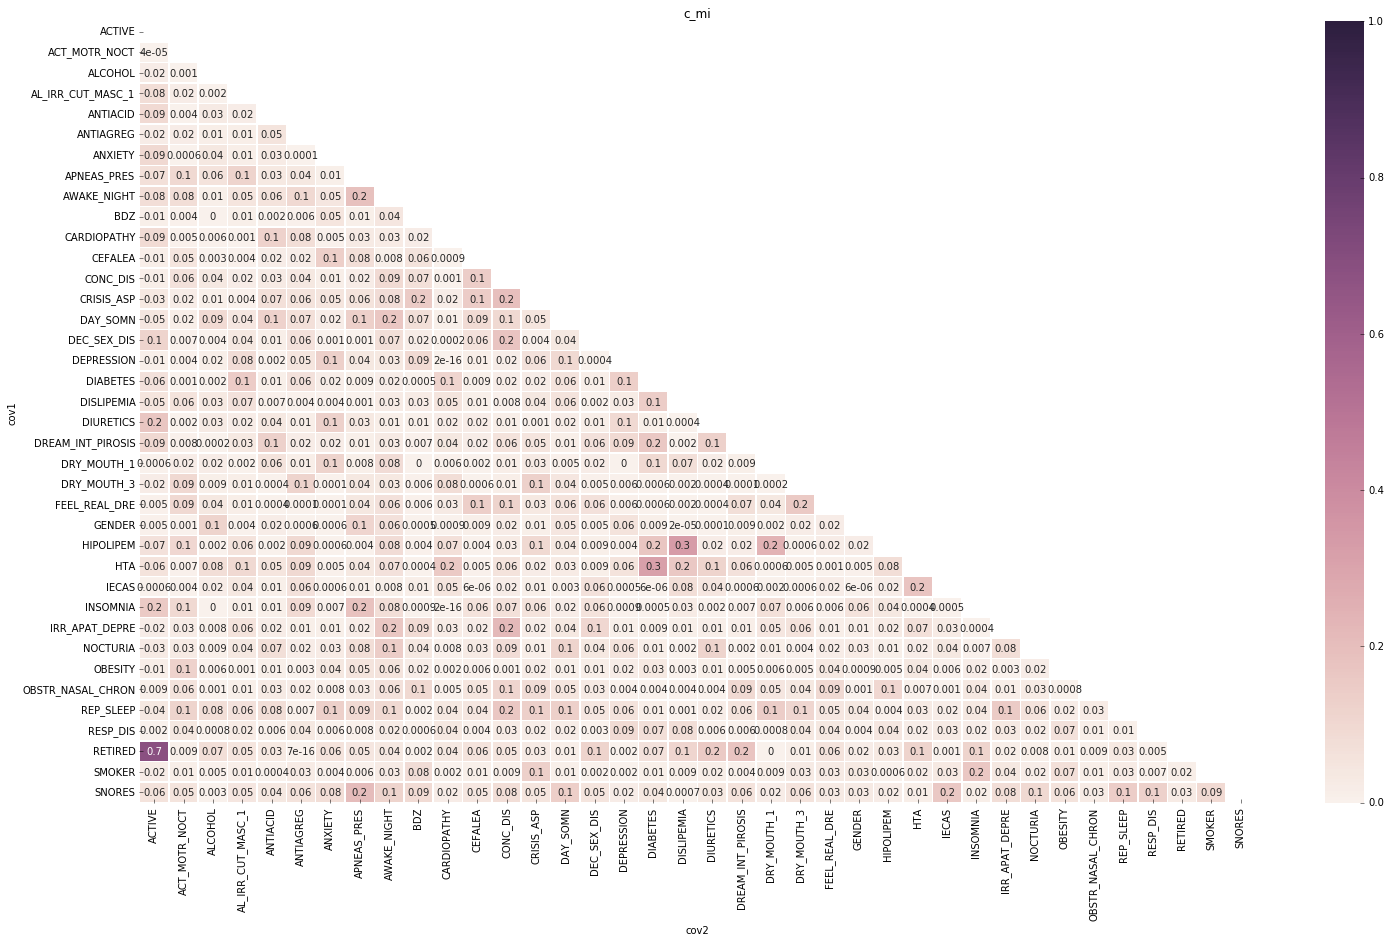

In [351]:
for c in ["c_sp","c_mi"]: #,"c_mi"
    pvt = dfCorr.pivot_table(index="cov1",columns="cov2", values=c)
    pvt

    # Generate a mask for the upper triangle
    mask = np.zeros_like(pvt, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    #Plot
    plt.figure(figsize=(25,14))
    plt.yticks(rotation=90)
    plt.xticks(rotation=90)
    sns.heatmap(pvt.iloc[:,:], annot=True, linewidths=.5, mask=mask, fmt=".1g")
    
    plt.title(c)

Categorical features to remove

In [352]:
to_del.extend([])

#### Significance test of features vs class

In [353]:
thrs = [3.5, 3.9, 4.0, 4.2, 4.5, 5.0]
thr = thrs[-4]
print "Selected threshold:",  thr

Selected threshold: 4.0


In [354]:
#dfImputed = pd.DataFrame(dfImputed, columns=reducedCols)
dfImputed["LABEL"] = df_all["LABEL"]

dfImputed["LABEL"][dfImputed["LABEL"] <= thr] = 0
dfImputed["LABEL"][dfImputed["LABEL"] > thr] = 1
dfImputed["LABEL"] = dfImputed["LABEL"].astype(int)

print pd.value_counts(dfImputed["LABEL"])

1    27
0    15
Name: LABEL, dtype: int64


[0.0, 0.0, 0.97, 2.08, 2.12, 2.6, 3.32, 3.5, 3.5, 3.8, 3.93, 4.0, 4.0, 4.0, 4.0, 4.5, 4.5, 4.99, 5.0, 5.0, 5.32, 5.5, 5.5, 5.5, 6.0, 6.0, 6.5, 6.5, 6.5, 6.5, 6.51, 7.0, 7.0, 7.0, 7.0, 7.0, 7.5, 7.5, 7.5, 7.5, 8.0, 8.0]


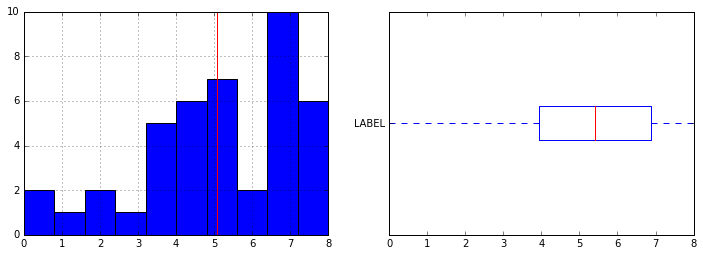

count   42.000
mean    5.075 
std     2.096 
min     0.000 
25%     3.948 
50%     5.410 
75%     6.877 
max     8.000 
Name: LABEL, dtype: float64

In [355]:
# Compute label column
lblCol = df_all["LABEL"]
lblCol = pd.to_numeric(lblCol)

plt.figure(figsize=(12,4))
ax = plt.subplot(1,2,1)
print lblCol.sort_values().tolist()
lblCol.hist(ax = ax)
ax.axvline(lblCol.mean(), c="r")
ax = plt.subplot(1,2,2)
lblCol.plot(kind="box", ax=ax, rot=0, vert=False)
plt.show()
lblCol.describe()

#### Categorical features vs label (proportions)

In [356]:
import pandas as pd
import scipy.stats as scs


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return scs.chi2_contingency(result)

In [365]:
sigArr = []

GENDER
   LABEL  GENDER  count  perc
0  0     0.000    5     0.333
1  0     1.000    10    0.667
2  1     0.000    8     0.296
3  1     1.000    19    0.704
0.00990274093722 0.92073135051 ['no']
[ 0.01915709] [ 0.88991708] ['no']


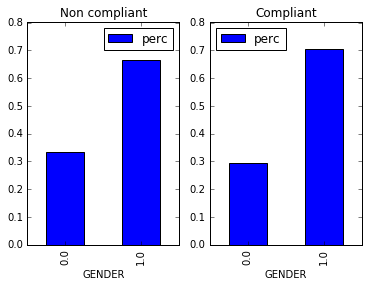

ACTIVE
   LABEL  ACTIVE  count  perc
0  0     0.000    7     0.467
1  0     1.000    8     0.533
2  1     0.000    10    0.370
3  1     1.000    17    0.630
0.0790588235294 0.77857693838 ['no']
[ 0.15022222] [ 0.69832309] ['no']


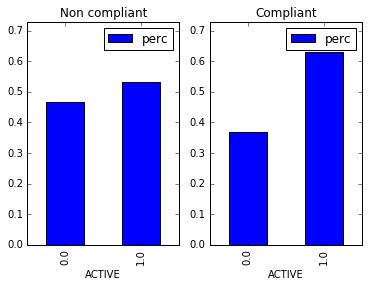

RETIRED
   LABEL  RETIRED  count  perc
0  0     0.000     9     0.600
1  0     1.000     6     0.400
2  1     0.000     19    0.704
3  1     1.000     8     0.296
0.116666666667 0.732678261376 ['no']
[ 0.31111111] [ 0.57699916] ['no']


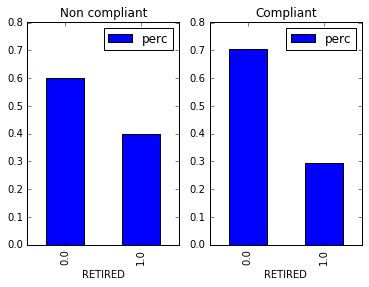

SMOKER
   LABEL  SMOKER  count  perc
0  0     0.000    9     0.600
1  0     1.000    6     0.400
2  1     0.000    17    0.630
3  1     1.000    10    0.370
0.0201923076923 0.887001302518 ['no']
[ 0.02222222] [ 0.88149745] ['no']


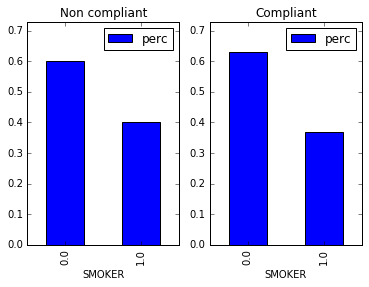

ALCOHOL
   LABEL  ALCOHOL  count  perc
0  0     0.000     10    0.667
1  0     1.000     5     0.333
2  1     0.000     14    0.519
3  1     1.000     13    0.481
0.36512345679 0.545674475979 ['no']
[ 0.49382716] [ 0.48222504] ['no']


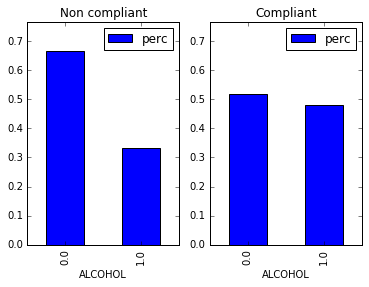

DEPRESSION
   LABEL  DEPRESSION  count  perc
0  0     0.000        14    0.933
1  0     1.000        1     0.067
2  1     0.000        21    0.778
3  1     1.000        6     0.222
0.746666666667 0.387533640255 ['no']
[ 1.4] [ 0.23672357] ['no']


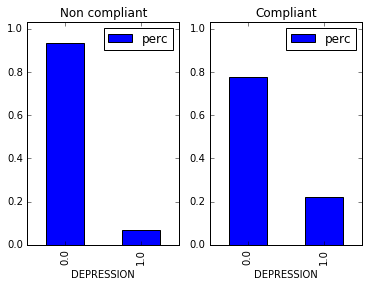

ANXIETY
   LABEL  ANXIETY  count  perc
0  0     0.000     11    0.733
1  0     1.000     4     0.267
2  1     0.000     22    0.815
3  1     1.000     5     0.185
0.0502805836139 0.822575754748 ['no']
[ 0.29876543] [ 0.58465742] ['no']


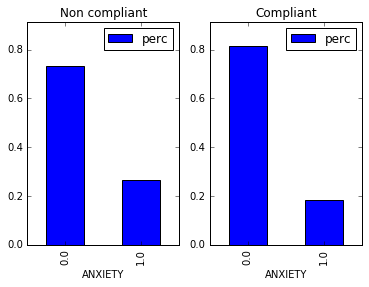

HTA
   LABEL   HTA  count  perc
0  0     0.000  10    0.667
1  0     1.000  5     0.333
2  1     0.000  7     0.259
3  1     1.000  20    0.741
5.05976470588 0.024487562385 ['yes']
[ 2.68888889] [ 0.10105026] ['no']


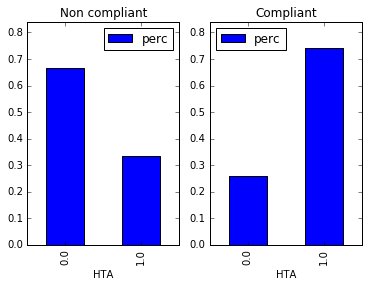

CARDIOPATHY
   LABEL  CARDIOPATHY  count  perc
0  0     0.000         12    0.800
1  0     1.000         3     0.200
2  1     0.000         18    0.667
3  1     1.000         9     0.333
0.313703703704 0.575416287928 ['no']
[ 0.6] [ 0.43857803] ['no']


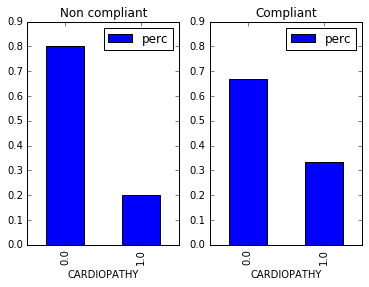

RESP_DIS
   LABEL  RESP_DIS  count  perc
0  0     0.000      12    0.800
1  0     1.000      3     0.200
2  1     0.000      19    0.704
3  1     1.000      8     0.296
0.0985337243402 0.753596368123 ['no']
[ 0.34141414] [ 0.55901409] ['no']


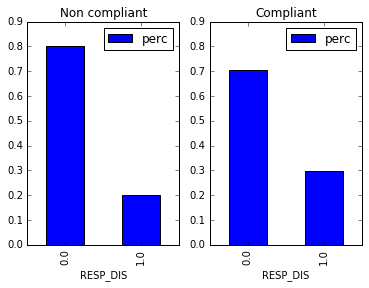

DIABETES
   LABEL  DIABETES  count  perc
0  0     0.000      11    0.733
1  0     1.000      4     0.267
2  1     0.000      18    0.667
3  1     1.000      9     0.333
0.00990274093722 0.92073135051 ['no']
[ 0.13846154] [ 0.70981527] ['no']


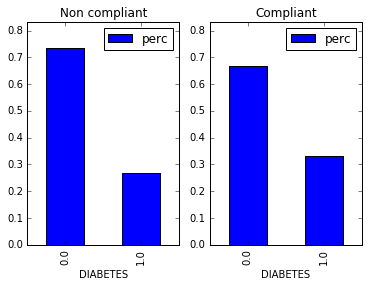

OBESITY
   LABEL  OBESITY  count  perc
0  0     0.000     6     0.400
1  0     1.000     9     0.600
2  1     0.000     6     0.222
3  1     1.000     21    0.778
0.749259259259 0.386710855045 ['no']
[ 0.42666667] [ 0.51362911] ['no']


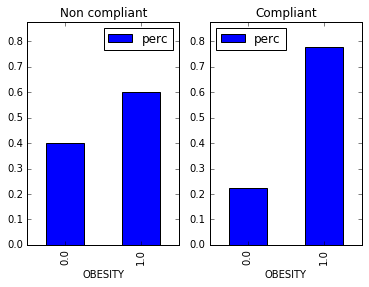

DISLIPEMIA
   LABEL  DISLIPEMIA  count  perc
0  0     0.000        8     0.533
1  0     1.000        7     0.467
2  1     0.000        18    0.667
3  1     1.000        9     0.333
0.271474358974 0.602344470315 ['no']
[ 0.45] [ 0.50233495] ['no']


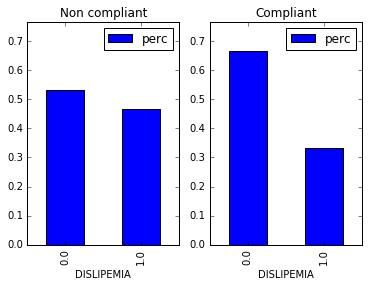

OBSTR_NASAL_CHRON
   LABEL  OBSTR_NASAL_CHRON  count  perc
0  0     0.000               8     0.533
1  0     1.000               7     0.467
2  1     0.000               19    0.704
3  1     1.000               8     0.296
0.589958847737 0.442435032483 ['no']
[ 0.7837037] [ 0.3760108] ['no']


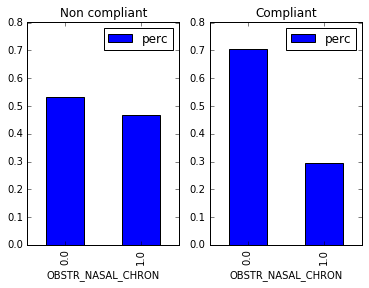

SNORES
   LABEL  SNORES  count  perc
0  0     1.000    1     0.067
1  0     2.000    5     0.333
2  0     3.000    9     0.600
3  1     1.000    2     0.074
4  1     2.000    5     0.185
5  1     3.000    20    0.741
1.17292464879 0.556291787686 ['no']
[ 0.06545455] [ 0.79807372] ['no']


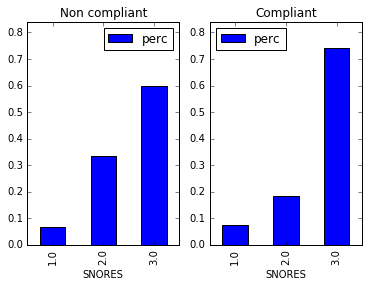

REP_SLEEP
   LABEL  REP_SLEEP  count  perc
0  0     0.000       3     0.200
1  0     1.000       2     0.133
2  0     2.000       8     0.533
3  0     3.000       2     0.133
4  1     0.000       8     0.296
5  1     1.000       5     0.185
6  1     2.000       11    0.407
7  1     3.000       3     0.111
0.874981392876 0.831460787804 ['no']
[ 0.48] [ 0.48842232] ['no']


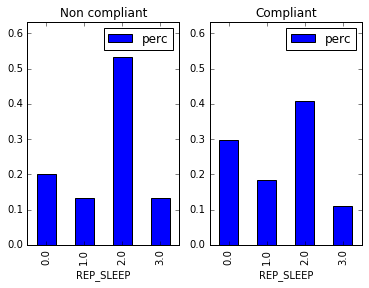

CRISIS_ASP
   LABEL  CRISIS_ASP  count  perc
0  0     0.000        6     0.400
1  0     1.000        7     0.467
2  0     2.000        2     0.133
3  1     0.000        18    0.667
4  1     1.000        7     0.259
5  1     2.000        2     0.074
2.8 0.246596963942 ['no']
[ 1.95555556] [ 0.16198944] ['no']


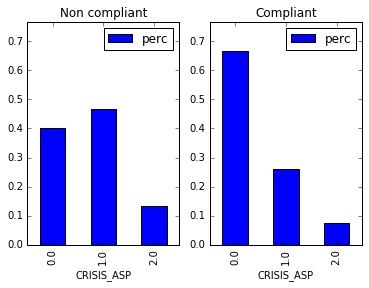

NOCTURIA
   LABEL  NOCTURIA  count  perc
0  0     0.000      4     0.267
1  0     1.000      5     0.333
2  0     2.000      1     0.067
3  0     3.000      5     0.333
4  1     0.000      5     0.185
5  1     1.000      7     0.259
6  1     2.000      4     0.148
7  1     3.000      11    0.407
1.16061728395 0.762464566771 ['no']
[ 0.56] [ 0.45426024] ['no']


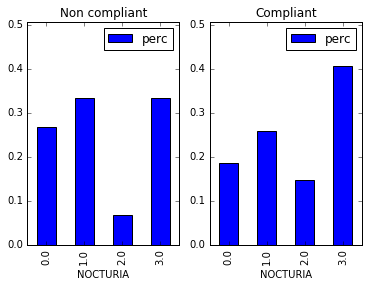

APNEAS_PRES
   LABEL  APNEAS_PRES  count  perc
0  0     0.000         4     0.267
1  0     1.000         5     0.333
2  0     2.000         4     0.267
3  0     3.000         2     0.133
4  1     0.000         6     0.222
5  1     1.000         5     0.185
6  1     2.000         9     0.333
7  1     3.000         7     0.259
1.82093067426 0.610390813319 ['no']
[ 0.84691358] [ 0.35742694] ['no']


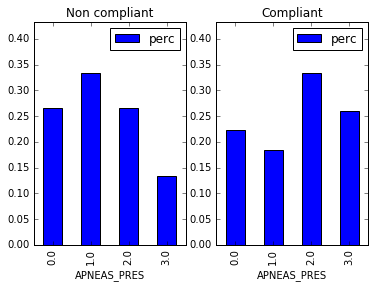

CEFALEA
   LABEL  CEFALEA  count  perc
0  0     0.000     6     0.400
1  0     1.000     9     0.600
2  1     0.000     23    0.852
3  1     1.000     4     0.148
7.21909814324 0.00721319392413 ['yes']
[ 6.36068376] [ 0.01166766] ['yes']


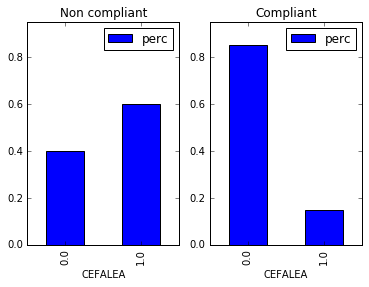

DAY_SOMN
   LABEL  DAY_SOMN  count  perc
0  0     0.000      4     0.267
1  0     1.000      6     0.400
2  0     2.000      3     0.200
3  0     3.000      2     0.133
4  1     0.000      9     0.333
5  1     1.000      5     0.185
6  1     2.000      7     0.259
7  1     3.000      6     0.222
2.37967365967 0.497429579955 ['no']
[ 0.21373737] [ 0.64385373] ['no']


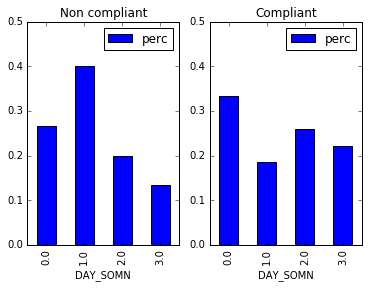

AWAKE_NIGHT
   LABEL  AWAKE_NIGHT  count  perc
0  0     0.000         7     0.467
1  0     1.000         3     0.200
2  0     2.000         4     0.267
3  0     3.000         1     0.067
4  1     0.000         14    0.519
5  1     1.000         2     0.074
6  1     2.000         7     0.259
7  1     3.000         4     0.148
1.87609427609 0.598517570976 ['no']
[ 0.1037037] [ 0.74742952] ['no']


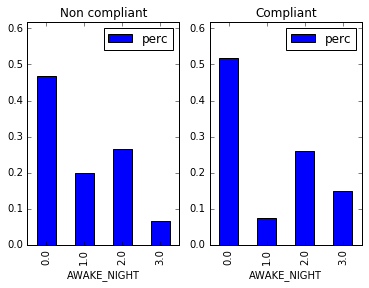

CONC_DIS
   LABEL  CONC_DIS  count  perc
0  0     0.000      9     0.600
1  0     1.000      1     0.067
2  0     2.000      5     0.333
3  1     0.000      20    0.741
4  1     1.000      6     0.222
5  1     2.000      1     0.037
7.60255427842 0.0223422195029 ['yes']
[ 4.07134503] [ 0.04361653] ['yes']


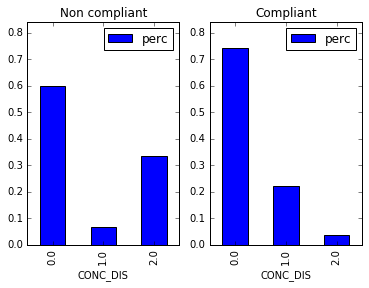

IRR_APAT_DEPRE
   LABEL  IRR_APAT_DEPRE  count  perc
0  0     0.000            5     0.333
1  0     1.000            6     0.400
2  0     2.000            4     0.267
3  1     0.000            18    0.667
4  1     1.000            7     0.259
5  1     2.000            2     0.074
5.07731945993 0.0789721729296 ['no']
[ 4.48088889] [ 0.03427589] ['yes']


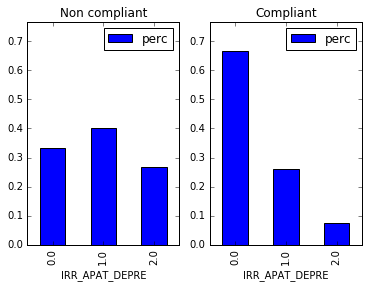

INSOMNIA
   LABEL  INSOMNIA  count  perc
0  0     0.000      10    0.667
1  0     1.000      5     0.333
2  1     0.000      25    0.926
3  1     1.000      2     0.074
2.98666666667 0.0839528182931 ['no']
[ 3.88888889] [ 0.04860657] ['yes']


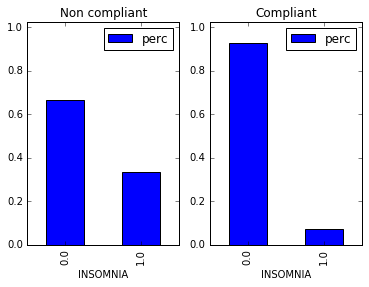

ACT_MOTR_NOCT
   LABEL  ACT_MOTR_NOCT  count  perc
0  0     0.000           9     0.600
1  0     1.000           6     0.400
2  1     0.000           18    0.667
3  1     1.000           9     0.333
0.00921810699588 0.923511857386 ['no']
[ 0.12] [ 0.72903449] ['no']


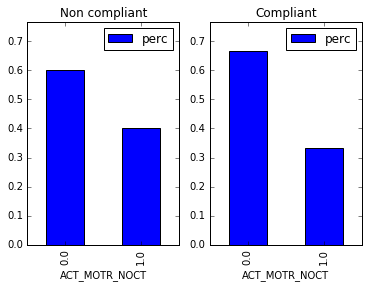

FEEL_REAL_DRE
   LABEL  FEEL_REAL_DRE  count  perc
0  0     0.000           11    0.733
1  0     1.000           4     0.267
2  1     0.000           22    0.815
3  1     1.000           5     0.185
0.0502805836139 0.822575754748 ['no']
[ 0.29876543] [ 0.58465742] ['no']


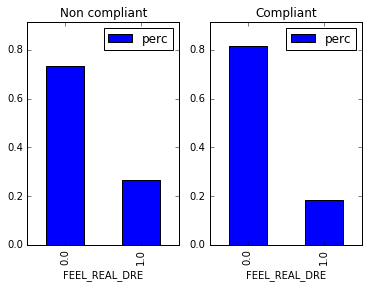

DREAM_INT_PIROSIS
   LABEL  DREAM_INT_PIROSIS  count  perc
0  0     0.000               12    0.800
1  0     1.000               3     0.200
2  1     0.000               21    0.778
3  1     1.000               6     0.222
0.0502805836139 0.822575754748 ['no']
[ 0.02222222] [ 0.88149745] ['no']


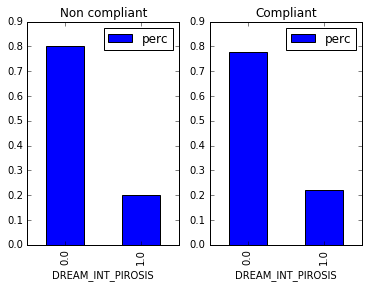

DEC_SEX_DIS
   LABEL  DEC_SEX_DIS  count  perc
0  0     0.000         9     0.600
1  0     1.000         6     0.400
2  1     0.000         16    0.593
3  1     1.000         11    0.407
0.0790588235294 0.77857693838 ['no']
[ 0.00130719] [ 0.97115871] ['no']


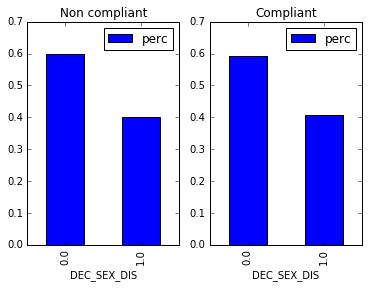

IECAS
   LABEL  IECAS  count  perc
0  0     0.000   13    0.867
1  0     1.000   2     0.133
2  1     0.000   16    0.593
3  1     1.000   11    0.407
2.22811671088 0.135518942157 ['no']
[ 2.34017094] [ 0.12607572] ['no']


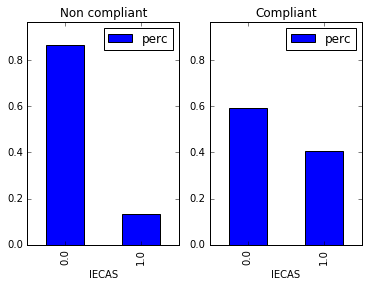

DIURETICS
   LABEL  DIURETICS  count  perc
0  0     0.000       13    0.867
1  0     1.000       2     0.133
2  1     0.000       19    0.704
3  1     1.000       8     0.296
0.65625 0.417886964318 ['no']
[ 1.07555556] [ 0.29969394] ['no']


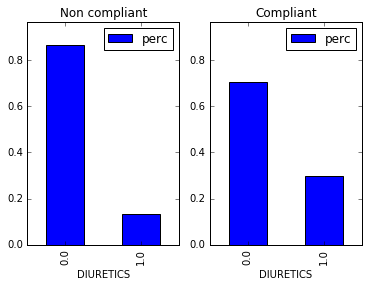

ANTIAGREG
   LABEL  ANTIAGREG  count  perc
0  0     0.000       15    1.000
1  1     0.000       18    0.667
2  1     1.000       9     0.333
4.53782267116 0.0331537369765 ['yes']
[ 5.] [ 0.02534732] ['yes']


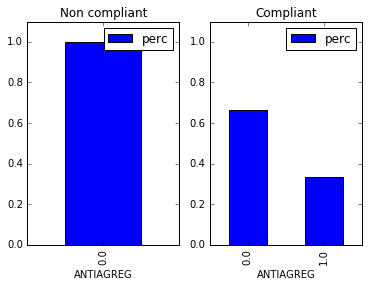

ANTIACID
   LABEL  ANTIACID  count  perc
0  0     0.000      12    0.800
1  0     1.000      3     0.200
2  1     0.000      20    0.741
3  1     1.000      7     0.259
0.00291666666667 0.956930246487 ['no']
[ 0.14222222] [ 0.70608174] ['no']


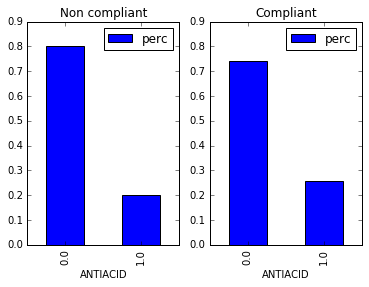

HIPOLIPEM
   LABEL  HIPOLIPEM  count  perc
0  0     0.000       10    0.667
1  0     1.000       5     0.333
2  1     0.000       17    0.630
3  1     1.000       10    0.370
0.00921810699588 0.923511857386 ['no']
[ 0.03703704] [ 0.84738966] ['no']


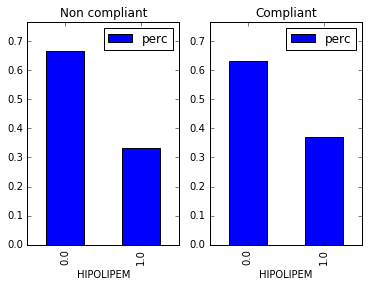

BDZ
   LABEL   BDZ  count  perc
0  0     0.000  11    0.733
1  0     1.000  4     0.267
2  1     0.000  24    0.889
3  1     1.000  3     0.111
0.746666666667 0.387533640255 ['no']
[ 1.4] [ 0.23672357] ['no']


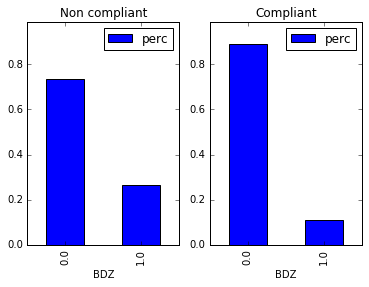

AL_IRR_CUT_MASC_1
   LABEL  AL_IRR_CUT_MASC_1  count  perc
0  0     0.000               11    0.733
1  0     1.000               4     0.267
2  1     0.000               23    0.852
3  1     1.000               4     0.148
0.277941176471 0.598053828561 ['no']
[ 0.71111111] [ 0.3990752] ['no']


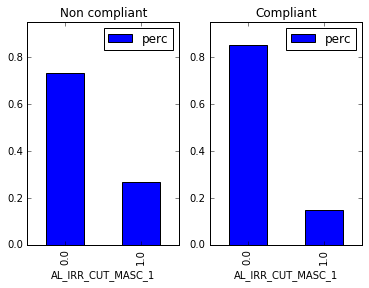

DRY_MOUTH_1
   LABEL  DRY_MOUTH_1  count  perc
0  0     0.000         7     0.467
1  0     1.000         8     0.533
2  1     0.000         17    0.630
3  1     1.000         10    0.370
0.486111111111 0.485667196335 ['no']
[ 0.59753086] [ 0.43952167] ['no']


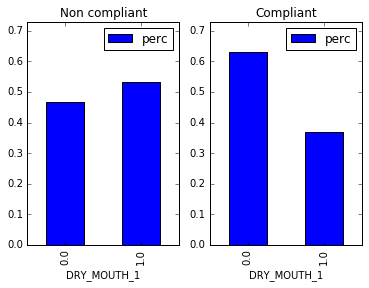

ABANDON_3
   LABEL  ABANDON_3  count  perc
0  0     0.000       14    0.933
1  0     1.000       1     0.067
2  1     0.000       27    1.000
0.0910569105691 0.762837788253 ['no']
[ 1.8] [ 0.17971249] ['no']


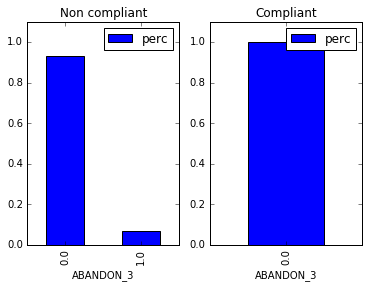

AL_IRR_CUT_MASC_3
   LABEL  AL_IRR_CUT_MASC_3  count  perc
0  0     0.000               15    1.000
1  1     0.000               26    0.963
2  1     1.000               1     0.037
0.0910569105691 0.762837788253 ['no']
[ 0.55555556] [ 0.45605654] ['no']


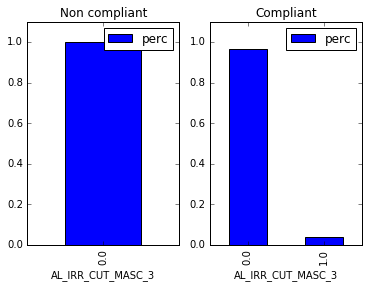

DRY_MOUTH_3
   LABEL  DRY_MOUTH_3  count  perc
0  0     0.000         11    0.733
1  0     1.000         4     0.267
2  1     0.000         22    0.815
3  1     1.000         5     0.185
0.0502805836139 0.822575754748 ['no']
[ 0.29876543] [ 0.58465742] ['no']


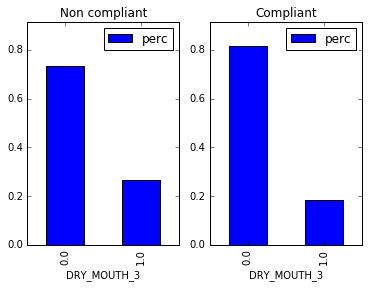

CONG_NASAL_3
   LABEL  CONG_NASAL_3  count  perc
0  0     0.000          15    1.000
1  1     0.000          27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


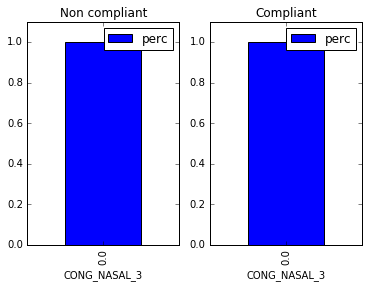

RUNNY_NOSE_3
   LABEL  RUNNY_NOSE_3  count  perc
0  0     0.000          15    1.000
1  1     0.000          27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


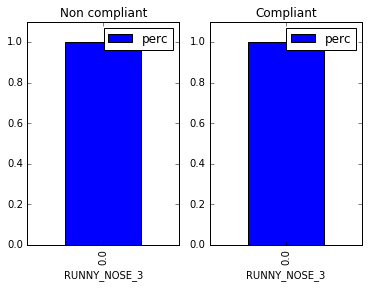

SNEEZING_3
   LABEL  SNEEZING_3  count  perc
0  0     0.000        15    1.000
1  1     0.000        27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


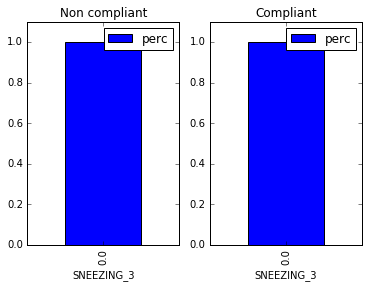

SINUSITIS_3
   LABEL  SINUSITIS_3  count  perc
0  0     0.000         15    1.000
1  1     0.000         27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


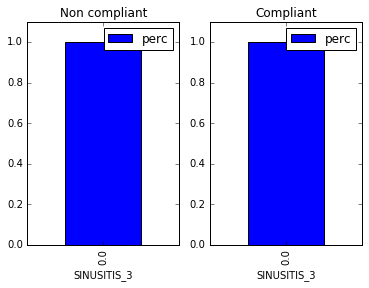

NOSEBLEED_3
   LABEL  NOSEBLEED_3  count  perc
0  0     0.000         15    1.000
1  1     0.000         27    1.000
0.0 1.0 ['no']
[ nan] [ nan] ['no']


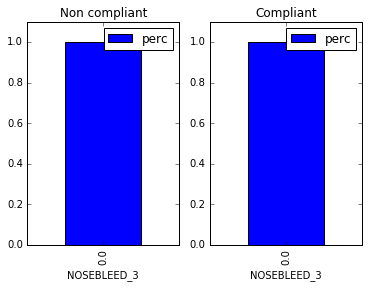

DISCOMFORT_3
   LABEL  DISCOMFORT_3  count  perc
0  0     0.000          14    0.933
1  0     1.000          1     0.067
2  1     0.000          27    1.000
0.0910569105691 0.762837788253 ['no']
[ 1.8] [ 0.17971249] ['no']


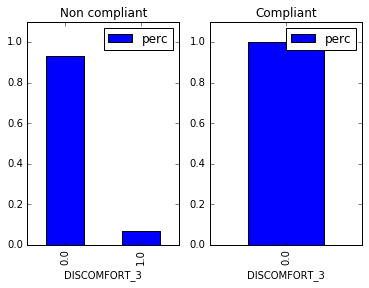

ADDED_DRUGS_3
   LABEL  ADDED_DRUGS_3  count  perc
0  0     0.000           15    1.000
1  1     0.000           24    0.889
2  1     1.000           3     0.111
0.510541310541 0.474904620748 ['no']
[ 1.66666667] [ 0.1967056] ['no']


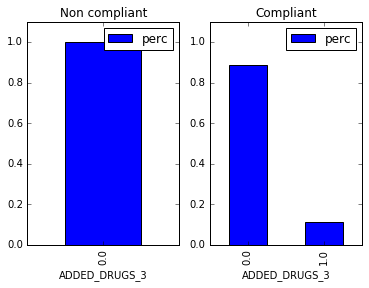

REMOVED_DRUGS_3
   LABEL  REMOVED_DRUGS_3  count  perc
0  0     0.000             15    1.000
1  1     0.000             24    0.889
2  1     1.000             3     0.111
0.510541310541 0.474904620748 ['no']
[ 1.66666667] [ 0.1967056] ['no']


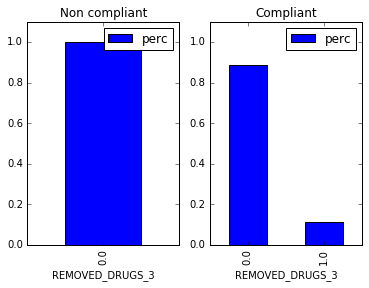

In [366]:
from scipy.stats import chisquare

for i in range(len(catCols)):
    if catCols[i] == 1:
                
        gr = dfImputed.groupby(["LABEL",dfImputed.columns[i]]).count().iloc[:,:1].reset_index()
        gr["count"] = gr.iloc[:,2]
        gr["perc"] = 0.0
        for j in range(gr.shape[0]):
            if gr["LABEL"].iloc[j] == 0:
                gr.set_value(j,"perc", gr.iloc[j]["count"]/float(gr[gr["LABEL"] == 0]["count"].sum()))
            else:
                gr.set_value(j,"perc", gr.iloc[j]["count"]/float(gr[gr["LABEL"] == 1]["count"].sum()))

        #Significance tests
        r1, p1 = chi2(dfImputed.iloc[:,i].values.astype(int).reshape(-1,1),dfImputed["LABEL"].values.astype(int).reshape(-1,1))        
        r,p,df,kounts = chi_square_of_df_cols(dfImputed, dfImputed.columns[i], 'LABEL')
        
        #if p < 0.05 or p1 < 0.05:
            
        sigArr.append([dfImputed.columns[i], p, p1[0], "cat"])
        print dfImputed.columns[i]        
        print gr.loc[:,["LABEL", dfImputed.columns[i], "count","perc"]]            
        print r, p, ["yes" if p < 0.05 else "no"]
        print r1, p1, ["yes" if p1 < 0.05 else "no"]

        ax = plt.subplot(1,2,1)
        gr[gr.LABEL == 0].loc[:,[dfImputed.columns[i], "perc"]].plot(ax=ax,kind="bar",x=dfImputed.columns[i],y="perc")

        ax.set_ylim(0,np.nanmax(gr["perc"])[0]+.1)
        ax.set_title("Non compliant")
        ax = plt.subplot(1,2,2)
        gr[gr.LABEL == 1].loc[:,[dfImputed.columns[i], "perc"]].plot(ax=ax,kind="bar",x=dfImputed.columns[i],y="perc")
        ax.set_ylim(0,np.nanmax(gr["perc"])[0]+.1)
        ax.set_title("Compliant")
        plt.show()

#### Numerical data

AGE
   LABEL   mean    std    max    min  count
0 0.000  51.467 12.705 71.000 33.000 15.000
1 1.000  59.963 11.650 81.000 40.000 27.000
[ 1687.54068488] [ 0.] ['yes']
[ 41.07968701] [ 0.] ['yes']
0.0 4.32526922354e-16 ['yes']


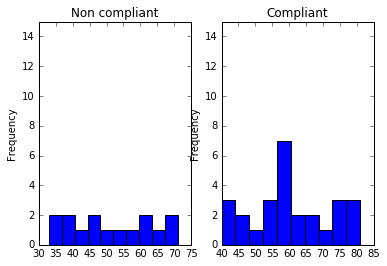

SMOKE_PACK_YEAR
   LABEL    mean     std       max   min  count
0 0.000  139.667 228.694 730.000   0.000 15.000
1 1.000  159.704 269.319 1,095.000 0.000 27.000
[ 14.96710328] [ 0.00021848] ['yes']
[ 3.86873407] [ 0.00021848] ['yes']
793.5 0.199856359845 ['no']


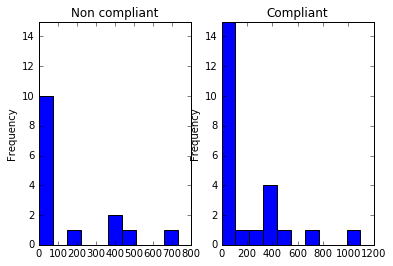

SMOKE_EX_YEAR
   LABEL  mean   std    max   min  count
0 0.000  0.733 2.086 8.000  0.000 15.000
1 1.000  3.787 6.525 20.000 0.000 27.000
[ 0.0648089] [ 0.79968801] ['no']
[-0.25457591] [ 0.79968801] ['no']
682.5 0.0248686589155 ['yes']


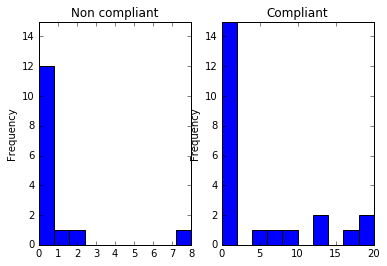

ALCOHOL_GR_DAY
   LABEL  mean    std    max   min  count
0 0.000  4.333 10.499 40.000 0.000 15.000
1 1.000  4.354 8.694  40.000 0.000 27.000
[ 0.48423456] [ 0.48847808] ['no']
[ 0.69586964] [ 0.48847808] ['no']
759.0 0.117314849469 ['no']


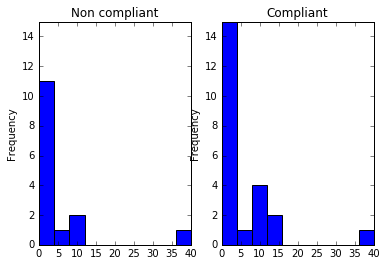

CAFES_DAY
   LABEL  mean   std   max   min  count
0 0.000  1.667 1.345 5.000 0.000 15.000
1 1.000  1.185 1.265 4.500 0.000 27.000
[ 0.27794834] [ 0.59947261] ['no']
[ 0.52720806] [ 0.59947261] ['no']
726.0 0.0736777645431 ['no']


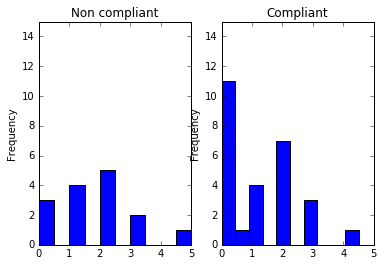

SLEEP_TIME
   LABEL    mean    std     max     min  count
0 0.000  391.917 75.338 499.000 238.000 15.000
1 1.000  388.556 74.005 500.000 173.000 27.000
[ 4194.77112007] [ 0.] ['yes']
[ 64.76705274] [ 0.] ['yes']
0.0 4.355301361e-16 ['yes']


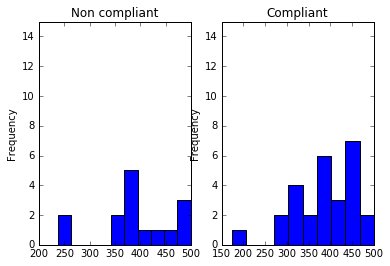

IAH
   LABEL   mean    std    max    min  count
0 0.000  46.609 18.965 79.070 15.500 15.000
1 1.000  56.754 21.484 94.500 22.900 27.000
[ 1089.29537087] [ 0.] ['yes']
[ 33.00447501] [ 0.] ['yes']
0.0 4.35831532601e-16 ['yes']


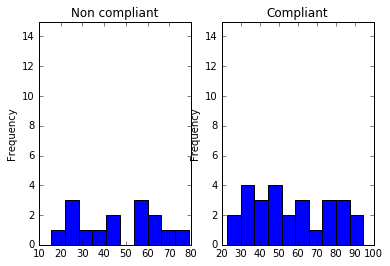

TIME_SAT<90%
   LABEL   mean    std     max   min  count
0 0.000  56.565 83.999 299.200 1.970 15.000
1 1.000  70.157 71.691 282.500 0.900 27.000
[ 188.26793079] [ 0.] ['yes']
[ 13.72107615] [ 0.] ['yes']
27.0 3.14936988134e-15 ['yes']


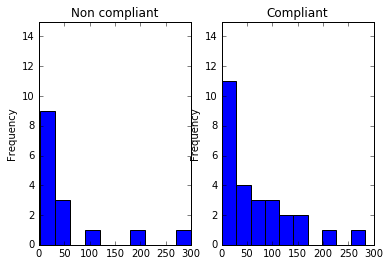

IND_DESAT
   LABEL   mean    std    max   min  count
0 0.000  36.229 21.290 72.200 6.380 15.000
1 1.000  41.045 27.670 90.700 1.970 27.000
[ 313.26376506] [ 0.] ['yes']
[ 17.69925888] [ 0.] ['yes']
0.0 4.35680809864e-16 ['yes']


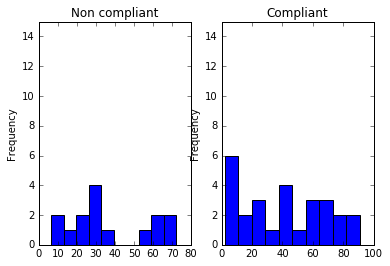

SIZE
   LABEL  mean   std   max   min  count
0 0.000  1.657 0.109 1.920 1.500 15.000
1 1.000  1.675 0.095 1.830 1.500 27.000
[ 20.27558395] [ 0.00002198] ['yes']
[ 4.50284176] [ 0.00002198] ['yes']
783.0 0.184339347156 ['no']


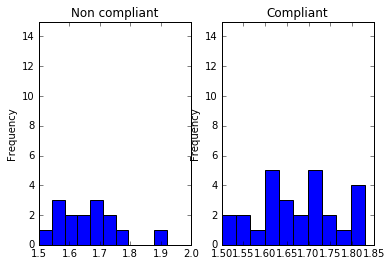

BMI
   LABEL   mean   std    max    min  count
0 0.000  33.150 8.163 50.220 23.330 15.000
1 1.000  34.214 5.438 44.780 23.390 27.000
[ 1307.36412262] [ 0.] ['yes']
[ 36.15749055] [ 0.] ['yes']
0.0 4.35680809864e-16 ['yes']


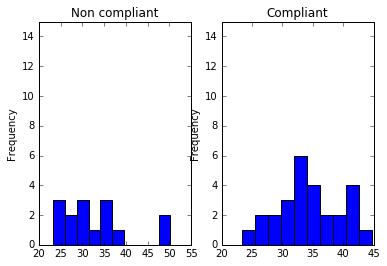

CIRC_NECK
   LABEL   mean   std    max    min  count
0 0.000  43.067 5.216 53.000 35.000 15.000
1 1.000  42.222 3.776 50.000 35.000 27.000
[ 1675.63906758] [ 0.] ['yes']
[ 40.93457057] [ 0.] ['yes']
0.0 4.19251643379e-16 ['yes']


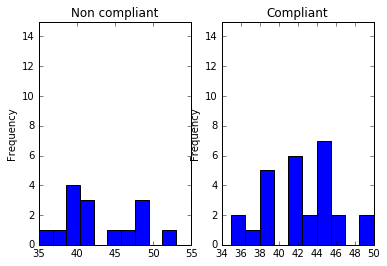

TAS_MEAN
   LABEL    mean    std     max     min  count
0 0.000  129.733 16.662 167.000 106.000 15.000
1 1.000  141.981 21.572 192.000 93.500  27.000
[ 2984.00196852] [ 0.] ['yes']
[ 54.62601915] [ 0.] ['yes']
0.0 4.3492793048e-16 ['yes']


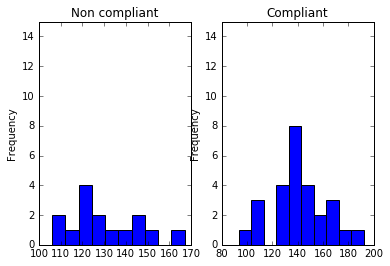

TAD_MEAN
   LABEL   mean    std     max    min  count
0 0.000  84.600 10.105 104.500 65.000 15.000
1 1.000  88.333 17.143 127.500 59.000 27.000
[ 2328.97851711] [ 0.] ['yes']
[ 48.25949147] [ 0.] ['yes']
0.0 4.34026088724e-16 ['yes']


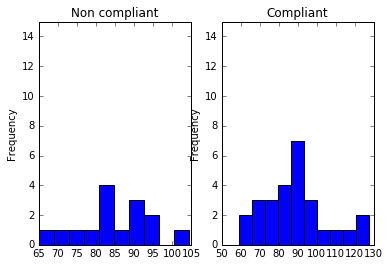

SAT_O2
   LABEL   mean   std    max    min  count
0 0.000  97.933 0.704 99.000 96.000 15.000
1 1.000  97.148 1.769 99.000 93.000 27.000
[ 2778.24041475] [ 0.] ['yes']
[ 52.70901645] [ 0.] ['yes']
0.0 2.06115961466e-16 ['yes']


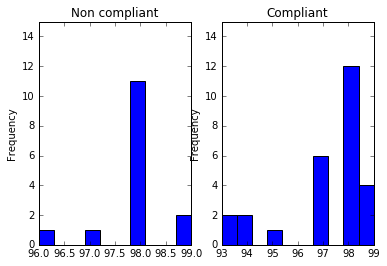

PRESS_CPAP
   LABEL   mean   std    max   min  count
0 0.000  10.760 1.233 13.000 8.000 15.000
1 1.000  11.015 1.153 14.000 9.000 27.000
[ 574.56990056] [ 0.] ['yes']
[ 23.97018775] [ 0.] ['yes']
0.0 3.3005819816e-16 ['yes']


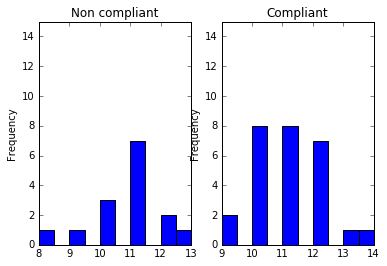

EPWORTH
   LABEL  mean   std    max   min  count
0 0.000  9.267 4.448 17.000 2.000 15.000
1 1.000  8.607 4.908 18.000 0.000 27.000
[ 144.48677922] [ 0.] ['yes']
[ 12.02026536] [ 0.] ['yes']
61.5 3.42067658337e-14 ['yes']


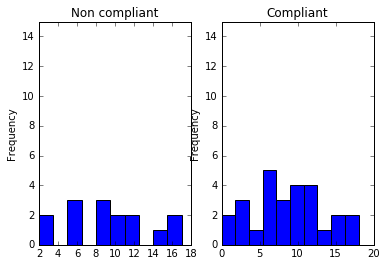

EUROQOL
   LABEL  mean   std   max   min  count
0 0.000  0.796 0.236 1.000 0.130 15.000
1 1.000  0.782 0.216 1.000 0.374 27.000
[ 0.82221981] [ 0.36718888] ['no']
[-0.90676337] [ 0.36718888] ['no']
630.0 0.0105804702212 ['yes']


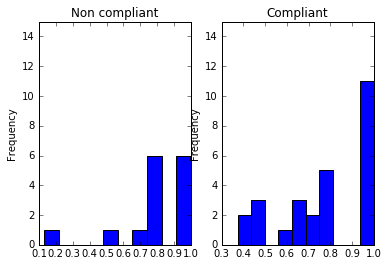

VISUAL
   LABEL   mean    std     max    min  count
0 0.000  64.000 18.146 90.000  40.000 15.000
1 1.000  54.852 25.665 100.000 5.000  27.000
[ 812.44457106] [ 0.] ['yes']
[ 28.50341332] [ 0.] ['yes']
0.0 3.63094837081e-16 ['yes']


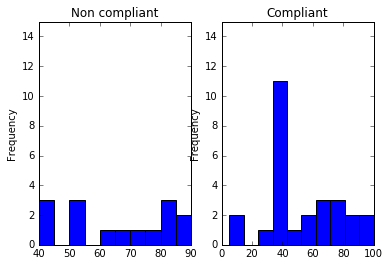

TOTAL_USE_HOURS_1
   LABEL    mean    std     max    min  count
0 0.000  182.804 86.338 318.000 10.000 15.000
1 1.000  237.062 96.429 451.000 98.000 27.000
[ 1367.28390716] [ 0.] ['yes']
[ 36.97680228] [ 0.] ['yes']
0.0 4.34026088724e-16 ['yes']


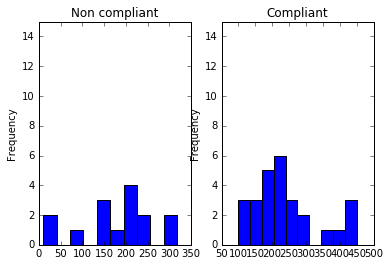

MEAN_USE_HOURS_1
   LABEL  mean   std   max   min  count
0 0.000  4.608 1.608 7.000 0.200 15.000
1 1.000  5.901 1.514 8.500 3.000 27.000
[ 162.33488985] [ 0.] ['yes']
[ 12.74107099] [ 0.] ['yes']
27.0 2.99715253084e-15 ['yes']


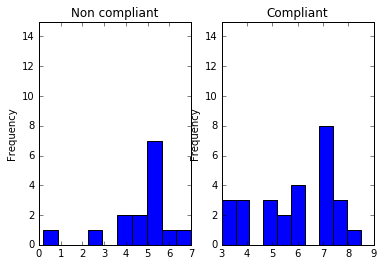

TAS_MEAN_1
   LABEL    mean    std     max     min  count
0 0.000  129.541 16.205 167.000 105.500 15.000
1 1.000  134.984 19.254 183.500 94.000  27.000
[ 2983.23179377] [ 0.] ['yes']
[ 54.61896918] [ 0.] ['yes']
0.0 4.32526922354e-16 ['yes']


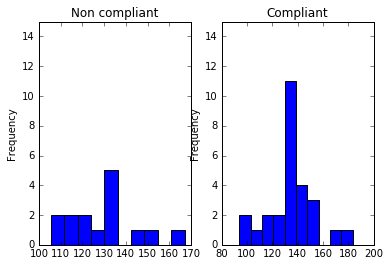

TAD_MEAN_1
   LABEL   mean    std     max    min  count
0 0.000  81.689 8.001  94.500  65.000 15.000
1 1.000  82.866 13.517 115.000 49.500 27.000
[ 2322.08705367] [ 0.] ['yes']
[ 48.18803849] [ 0.] ['yes']
0.0 4.25840680525e-16 ['yes']


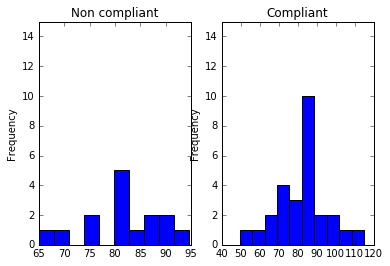

EPWORTH_1
   LABEL  mean   std    max   min  count
0 0.000  7.080 3.322 15.000 2.000 15.000
1 1.000  5.506 3.561 14.000 0.000 27.000
[ 101.53454287] [ 0.] ['yes']
[ 10.07643503] [ 0.] ['yes']
88.5 2.18992123257e-13 ['yes']


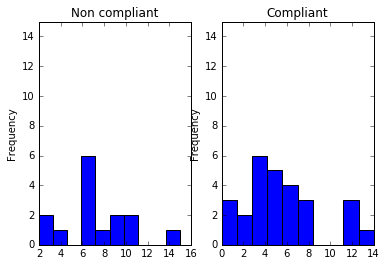

EUROQOL_1
   LABEL  mean   std   max   min  count
0 0.000  0.873 0.114 1.000 0.701 15.000
1 1.000  0.832 0.146 1.000 0.493 27.000
[ 0.17910357] [ 0.67325266] ['no']
[-0.4232063] [ 0.67325266] ['no']
630.0 0.0106401996528 ['yes']


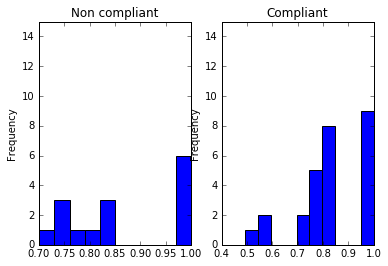

VISUAL_EUROQOL_1
   LABEL   mean    std     max    min  count
0 0.000  74.523 13.150 90.000  40.000 15.000
1 1.000  68.959 18.680 100.000 20.000 27.000
[ 1698.95178055] [ 0.] ['yes']
[ 41.21834277] [ 0.] ['yes']
0.0 3.94801890322e-16 ['yes']


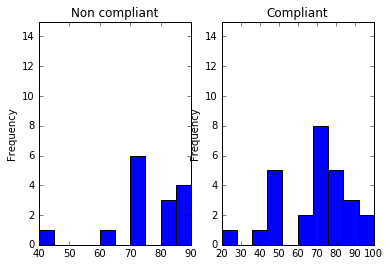

TOTAL_USE_HOURS_3
   LABEL    mean     std     max     min  count
0 0.000  342.899 158.425 594.000 59.000  15.000
1 1.000  554.837 138.431 812.000 223.000 27.000
[ 2378.88827131] [ 0.] ['yes']
[ 48.77384823] [ 0.] ['yes']
0.0 4.35680809864e-16 ['yes']


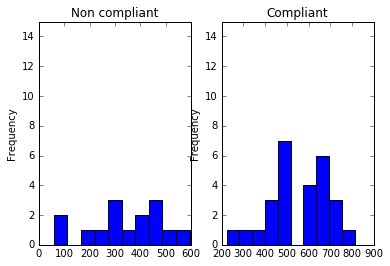

MEAN_USE_HOURS_3
   LABEL  mean   std   max   min  count
0 0.000  3.796 1.741 5.800 0.600 15.000
1 1.000  6.178 1.291 8.500 3.500 27.000
[ 142.73356495] [ 0.] ['yes']
[ 11.94711534] [ 0.] ['yes']
54.0 2.10573222026e-14 ['yes']


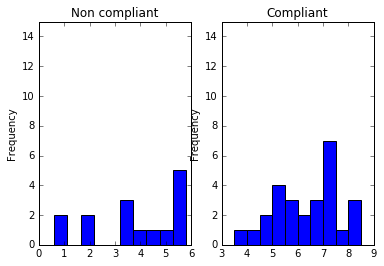

TAS_MEAN_3
   LABEL    mean    std     max     min  count
0 0.000  130.510 14.346 154.500 107.500 15.000
1 1.000  135.755 20.590 170.000 96.500  27.000
[ 2972.77083085] [ 0.] ['yes']
[ 54.52312198] [ 0.] ['yes']
0.0 4.33126004129e-16 ['yes']


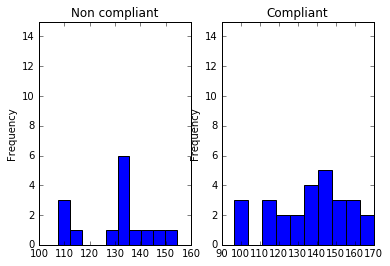

TAD_MEAN_3
   LABEL   mean    std     max    min  count
0 0.000  81.756 8.015  96.000  67.000 15.000
1 1.000  81.013 16.346 109.000 40.350 27.000
[ 2181.07152163] [ 0.] ['yes']
[ 46.70194345] [ 0.] ['yes']
0.0 4.33575826981e-16 ['yes']


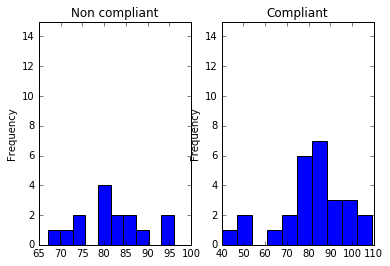

WEIGHT_3
   LABEL   mean    std     max    min  count
0 0.000  94.331 18.040 132.700 65.000 15.000
1 1.000  95.574 15.293 123.000 66.800 27.000
[ 2429.38907035] [ 0.] ['yes']
[ 49.28883312] [ 0.] ['yes']
0.0 4.350784085e-16 ['yes']


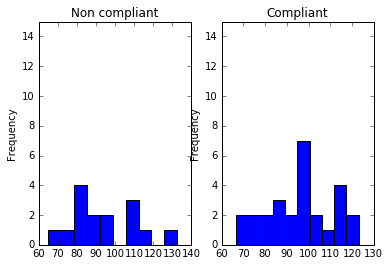

SIZE_3
   LABEL  mean   std   max   min  count
0 0.000  1.680 0.098 1.920 1.500 15.000
1 1.000  1.678 0.093 1.830 1.500 27.000
[ 20.75504515] [ 0.00001799] ['yes']
[ 4.55577053] [ 0.00001799] ['yes']
783.0 0.184345653896 ['no']


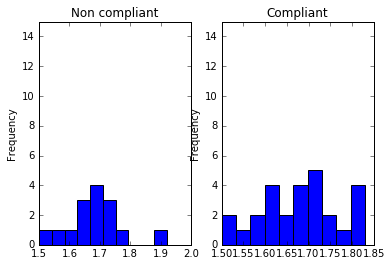

BMI_3
   LABEL   mean   std    max    min  count
0 0.000  34.238 8.077 52.440 23.870 15.000
1 1.000  34.051 5.577 47.460 25.670 27.000
[ 1318.63745442] [ 0.] ['yes']
[ 36.31304799] [ 0.] ['yes']
0.0 4.35680809864e-16 ['yes']


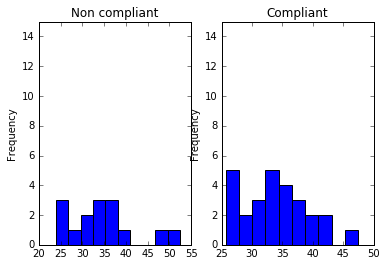

EPWORTH_3
   LABEL  mean   std    max   min  count
0 0.000  8.117 3.953 20.000 5.000 15.000
1 1.000  4.637 3.070 14.000 1.000 27.000
[ 107.20401013] [ 0.] ['yes']
[ 10.35393694] [ 0.] ['yes']
81.0 1.34490275807e-13 ['yes']


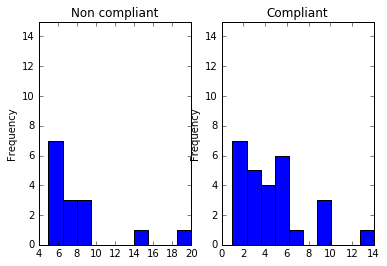

EUROQOL_3
   LABEL  mean   std   max   min  count
0 0.000  0.828 0.222 1.000 0.217 15.000
1 1.000  0.841 0.179 1.000 0.273 27.000
[ 0.28368022] [ 0.59573956] ['no']
[-0.53261639] [ 0.59573956] ['no']
630.0 0.0104675412233 ['yes']


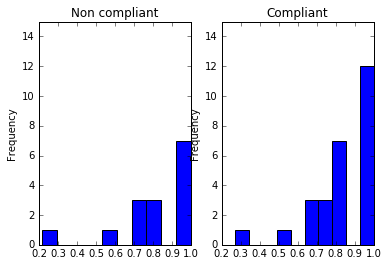

VISUAL_EUROQOL_3
   LABEL   mean    std     max    min  count
0 0.000  72.558 13.181 90.000  50.000 15.000
1 1.000  71.205 22.314 100.000 0.850  27.000
[ 839.47922554] [ 0.] ['yes']
[ 28.97376789] [ 0.] ['yes']
27.0 2.63489261455e-15 ['yes']


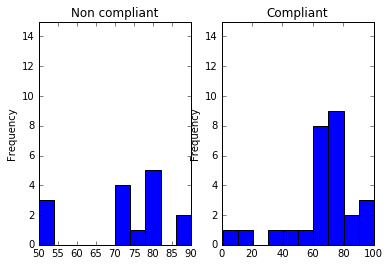

In [371]:
from scipy import stats

for i in range(len(catCols)):
    if catCols[i] == 0:

        r, p = f_oneway(np.log((dfImputed.iloc[:,i].values.astype(float)+1.0).reshape(-1,1)),dfImputed["LABEL"].values.astype(int).reshape(-1,1))
        r1, p1 = stats.ttest_ind(np.log(dfImputed.iloc[:,i].values.astype(float) + 1.0).reshape(-1,1), dfImputed["LABEL"].values.astype(int).reshape(-1,1))
        r2, p2 = stats.mannwhitneyu(np.log(dfImputed.iloc[:,i].values.astype(float) + 1.0).reshape(-1,1), dfImputed["LABEL"].values.astype(int).reshape(-1,1))
        
        #if p < 0.05 or p1 < 0.05:
                    
        gr = dfImputed[["LABEL",dfImputed.columns[i]]].groupby(["LABEL"]).agg({"std","mean","count","min","max"}).iloc[:,:6].reset_index()
        gr = pd.DataFrame(gr.values, columns=["LABEL","std","count","max","min","mean"])

        sigArr.append([dfImputed.columns[i], p1[0], p2, "num"])

        print dfImputed.columns[i]        
        print gr.loc[:,["LABEL","mean","std","max","min","count"]]
        print r, p, ["yes" if p < 0.05 else "no"]
        print r1, p1, ["yes" if p1 < 0.05 else "no"]            
        print r2, p2, ["yes" if p2 < 0.05 else "no"]            


        ax = plt.subplot(1,2,1)
        dfImputed[dfImputed.LABEL == 0][dfImputed.columns[i]].plot(ax=ax,kind="hist")#,x=dfImputed.columns[i],y="mean")
        ax.set_ylim(0,15)
        ax.set_title("Non compliant")
        ax = plt.subplot(1,2,2)
        dfImputed[dfImputed.LABEL == 1][dfImputed.columns[i]].plot(ax=ax,kind="hist")#,x=dfImputed.columns[i],y="mean")
        ax.set_ylim(0,15)
        ax.set_title("Compliant")
        plt.show()

In [370]:
print len(sigArr)
dfSigArr = pd.DataFrame(sigArr, columns=["column","pval1","pval2","type"])
dfSigArr[dfSigArr["pval2"]<0.05]

84


,column,pval1,pval2,type
19,CEFALEA,0.007,0.012,cat
22,CONC_DIS,0.022,0.044,cat
23,IRR_APAT_DEPRE,0.079,0.034,cat
24,INSOMNIA,0.084,0.049,cat
31,ANTIAGREG,0.033,0.025,cat
48,AGE,0.000,0.000,num
50,SMOKE_EX_YEAR,0.800,0.025,num
53,SLEEP_TIME,0.000,0.000,num
54,IAH,0.000,0.000,num
55,TIME_SAT<90%,0.000,0.000,num


### Clean features (optional)

In [316]:
df_all = df_all[df_all.columns[~df_all.columns.isin(to_del)]]
catCols = catCols[~dfImputed.columns[:-1].isin(to_del)]
dfImputed = dfImputed[dfImputed.columns[:-1][~dfImputed.columns[:-1].isin(to_del)]]
columns = df_all.columns

print len(columns)
print columns
print catCols.shape
print df_all.shape
print dfImputed.shape

71
Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL',
       u'TOTAL_USE_HOURS_1', u'MEAN_USE_HOURS_1', u'AL_IRR_CUT_MASC_1',
       u'DRY_MOUTH_1', u'TAS_MEAN_1', u'TAD_MEAN_1', u'EPWORTH_1',
       u'EUROQOL_1', u'VISUAL_EUROQOL_1', u'M

### SAVE filtered data

In [317]:
print index

if index == 0:
    fileName = os.path.join('resources','data_filtered_cl0_short_no_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_no_monit_14012016_final.pkl')
elif index == 1:
    fileName = os.path.join('resources','data_filtered_cl0_short_1m_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_1m_monit_14012016_final.pkl')
else:
    fileName = os.path.join('resources','data_filtered_cl0_short_3m_1m_monit_14012016_final.pkl')
    fileName1 = os.path.join('resources','mapping_filtered_cl0_short_3m_1m_monit_14012016_final.pkl')

df_all_codes = df_all.copy()
df_all_codes.insert(0,"CODIGO", codes)
df_all_codes.to_pickle(fileName)
print df_all.shape

#save feature mapping 
dfFeatures.to_pickle(fileName1)
print dfFeatures.shape

2
(42, 71)
(114, 6)


#### Post processing data description

In [318]:
print len(df_all.columns[catCols==1]), df_all.columns[catCols==1]

dfCat_1 = dfCatSum[dfCatSum.variable.isin(df_all.columns[catCols==1])]
dfCat_2 = dfSigArr[dfSigArr.column.isin(df_all.columns[catCols==1])]
dfCatFinal = pd.merge(dfCat_1, dfCat_2,left_on="variable", right_on="column")
dfCatFinal["sig."] = dfCatFinal.pval < 0.05

types = []
for n in dfCatFinal.variable:
    c = dfFeatures[dfFeatures["Name"] == n].Cat.values[0]
    types.append(c)
    
dfCatFinal["type"] = types

pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfCatFinal[["variable", "type","categories", "frequencies","ratios", "pval","sig."]].to_html(index=False)))

38 Index([u'GENDER', u'ACTIVE', u'RETIRED', u'SMOKER', u'ALCOHOL', u'DEPRESSION',
       u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS', u'DIABETES',
       u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'AL_IRR_CUT_MASC_1', u'DRY_MOUTH_1',
       u'DRY_MOUTH_3'],
      dtype='object')


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/pandas/core/indexes/base.py:1700: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 71 but corresponding boolean dimension is 70
  result = getitem(key)


variable,type,categories,frequencies,ratios,pval,sig.
DRY_MOUTH_3,SYMPTOMS,"[0.0, 1.0]","[33, 9]","[0.79, 0.21]",0.823,False


In [320]:
print len(df_all.columns[catCols==0]), df_all.columns[catCols==0]

dfNum_1 = dfImputed[dfImputed.columns[catCols==0]].describe().T
dfNum_1["variable"] = dfNum_1.index

dfNum_2 = dfSigArr[dfSigArr.column.isin(df_all.columns[catCols==0])]
dfNumFinal = pd.merge(dfNum_1, dfNum_2, left_on="variable", right_on="column")
dfNumFinal["sig."] = dfNumFinal.pval1 < 0.05

types = []
for n in dfNumFinal.variable:
    c = dfFeatures[dfFeatures["Name"] == n].Cat.values[0]
    types.append(c)
    
dfNumFinal["type"] = types
dfNumFinal = dfNumFinal[dfNumFinal.variable.str.contains("_3")]
pd.options.display.float_format = '{:,.3f}'.format
display(HTML(dfNumFinal[["variable","type","mean","std","max","25%","50%","75%","pval1","sig."]].to_html(index=False)))

32 Index([u'AGE', u'SMOKE_PACK_YEAR', u'SMOKE_EX_YEAR', u'ALCOHOL_GR_DAY',
       u'CAFES_DAY', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%', u'IND_DESAT',
       u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN', u'SAT_O2',
       u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL', u'TOTAL_USE_HOURS_1',
       u'MEAN_USE_HOURS_1', u'TAS_MEAN_1', u'TAD_MEAN_1', u'EPWORTH_1',
       u'EUROQOL_1', u'VISUAL_EUROQOL_1', u'MEAN_USE_HOURS_3', u'TAS_MEAN_3',
       u'TAD_MEAN_3', u'EPWORTH_3', u'EUROQOL_3', u'VISUAL_EUROQOL_3'],
      dtype='object')


variable,type,mean,std,max,25%,50%,75%,pval1,sig.
MEAN_USE_HOURS_3,CPAP_DEVICE,5.327,1.851,8.500,4.500,5.500,6.975,0.000,True
MEAN_USE_HOURS_3,CPAP_DEVICE,5.327,1.851,8.500,4.500,5.500,6.975,0.000,True
TAS_MEAN_3,VISIT_3,133.882,18.590,170.000,119.125,135.500,143.625,0.000,True
TAS_MEAN_3,VISIT_3,133.882,18.590,170.000,119.125,135.500,143.625,0.000,True
TAD_MEAN_3,VISIT_3,81.278,13.838,109.000,75.000,82.500,87.375,0.000,True
TAD_MEAN_3,VISIT_3,81.278,13.838,109.000,75.000,82.500,87.375,0.000,True
EPWORTH_3,VISIT_3,5.880,3.763,20.000,3.400,5.880,7.000,0.000,True
EPWORTH_3,VISIT_3,5.880,3.763,20.000,3.400,5.880,7.000,0.000,True
EUROQOL_3,VISIT_3,0.837,0.193,1.000,0.744,0.837,1.000,0.596,False
VISUAL_EUROQOL_3,VISIT_3,71.688,19.378,100.000,70.000,73.344,80.000,0.000,True


#### PCA visualisation

In [321]:
scaler = preprocessing.StandardScaler().fit(dfImputed)
df_all_scaled = scaler.transform(dfImputed)
df_all_scaled = pd.DataFrame(
    data = np.hstack((df_all_scaled, df_all.iloc[:,-1].reshape(-1,1))), 
    columns = columns)
print df_all_scaled.shape
print df_all_scaled.columns

(42, 71)
Index([u'GENDER', u'ACTIVE', u'RETIRED', u'AGE', u'SMOKER', u'SMOKE_PACK_YEAR',
       u'SMOKE_EX_YEAR', u'ALCOHOL', u'ALCOHOL_GR_DAY', u'CAFES_DAY',
       u'DEPRESSION', u'ANXIETY', u'HTA', u'CARDIOPATHY', u'RESP_DIS',
       u'DIABETES', u'OBESITY', u'DISLIPEMIA', u'OBSTR_NASAL_CHRON', u'SNORES',
       u'REP_SLEEP', u'CRISIS_ASP', u'NOCTURIA', u'APNEAS_PRES', u'CEFALEA',
       u'DAY_SOMN', u'AWAKE_NIGHT', u'CONC_DIS', u'IRR_APAT_DEPRE',
       u'INSOMNIA', u'ACT_MOTR_NOCT', u'FEEL_REAL_DRE', u'DREAM_INT_PIROSIS',
       u'DEC_SEX_DIS', u'IECAS', u'DIURETICS', u'ANTIAGREG', u'ANTIACID',
       u'HIPOLIPEM', u'BDZ', u'SLEEP_TIME', u'IAH', u'TIME_SAT<90%',
       u'IND_DESAT', u'SIZE', u'BMI', u'CIRC_NECK', u'TAS_MEAN', u'TAD_MEAN',
       u'SAT_O2', u'PRESS_CPAP', u'EPWORTH', u'EUROQOL', u'VISUAL',
       u'TOTAL_USE_HOURS_1', u'MEAN_USE_HOURS_1', u'AL_IRR_CUT_MASC_1',
       u'DRY_MOUTH_1', u'TAS_MEAN_1', u'TAD_MEAN_1', u'EPWORTH_1',
       u'EUROQOL_1', u'VISUAL_EUROQOL_1

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


In [322]:
pca = PCA()
X_SCALED = df_all_scaled.ix[:,:-1].values
X_r = pca.fit(X_SCALED).transform(X_SCALED)
print "DATASET: {}M".format(index)
print('explained variance ratio (first components): %s'
      % str(pca.explained_variance_ratio_))
print "explained variance ratio of 2 pcas:", np.sum(pca.explained_variance_ratio_[:2])

DATASET: 2M
explained variance ratio (first components): [ 0.12788952  0.0967036   0.08861545  0.05826667  0.0515038   0.04597842
  0.0440382   0.04139027  0.03792206  0.03526862  0.03262132  0.02936339
  0.02841621  0.02517912  0.02473449  0.021825    0.01978672  0.01849958
  0.01793362  0.0161207   0.01480842  0.01393038  0.01268197  0.01112182
  0.01026316  0.00933002  0.00870108  0.0077621   0.00706023  0.00663338
  0.00661068  0.00546149  0.00476524  0.00394069  0.00341766  0.00330009
  0.00233014  0.00179882  0.00169805  0.00137423  0.00095358  0.        ]
explained variance ratio of 2 pcas: 0.224593123079


/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  from ipykernel import kernelapp as app


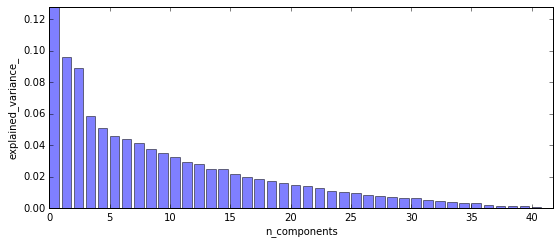

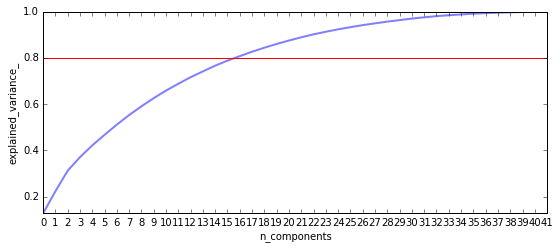

In [200]:
plt.figure(1, figsize=(10, 4))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.bar(range(len(pca.explained_variance_ratio_)),pca.explained_variance_ratio_, alpha=0.5)#, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()

plt.figure(1, figsize=(10, 4))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_), linewidth=2, alpha=0.5)
plt.axhline(0.8,c="r")
plt.xticks(range(len(pca.explained_variance_ratio_)),range(len(pca.explained_variance_ratio_)))
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.show()


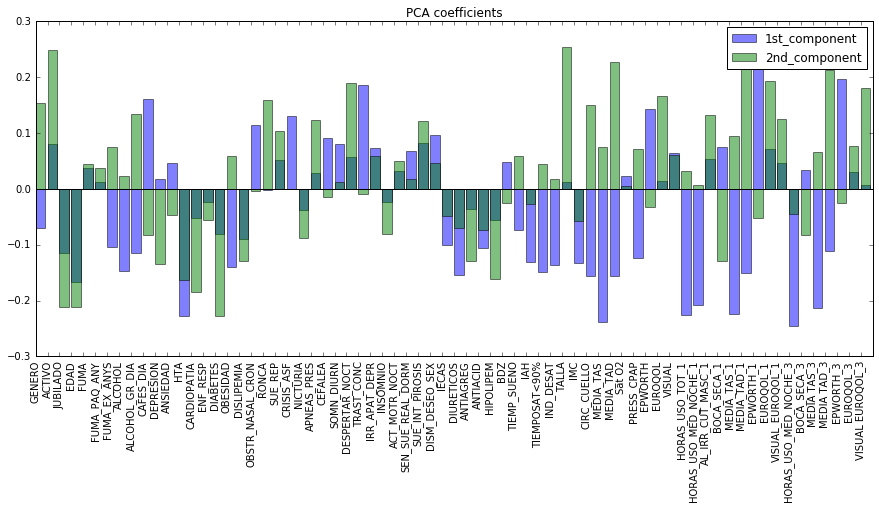

In [201]:
#Plot pca's coefficients
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
ax.bar(range(pca.components_.shape[1]), pca.components_[0,:],label="1st_component", alpha=0.5)
ax.bar(range(pca.components_.shape[1]), pca.components_[1,:],label="2nd_component", alpha=0.5)
ax.axhline(y=0,c="black")
plt.xticks(range(pca.components_.shape[1]),df_all_scaled.columns,rotation=90)
plt.title("PCA coefficients")
plt.legend()
plt.show()

In [202]:
thrs = [3.5, 3.9, 4.0, 4.2, 4.5, 5.0]
classes = [0,1]
colors = ["r","g"]


0 no cumplidor (<= 3.5) 9 (42, 71) (42, 42)
1 Cumplidor (> 3.5) 33 (42, 71) (42, 42)

0 no cumplidor (<= 3.9) 10 (42, 71) (42, 42)
1 Cumplidor (> 3.9) 32 (42, 71) (42, 42)

0 no cumplidor (<= 4.0) 15 (42, 71) (42, 42)
1 Cumplidor (> 4.0) 27 (42, 71) (42, 42)

0 no cumplidor (<= 4.2) 15 (42, 71) (42, 42)
1 Cumplidor (> 4.2) 27 (42, 71) (42, 42)

0 no cumplidor (<= 4.5) 17 (42, 71) (42, 42)
1 Cumplidor (> 4.5) 25 (42, 71) (42, 42)

0 no cumplidor (<= 5.0) 20 (42, 71) (42, 42)
1 Cumplidor (> 5.0) 22 (42, 71) (42, 42)


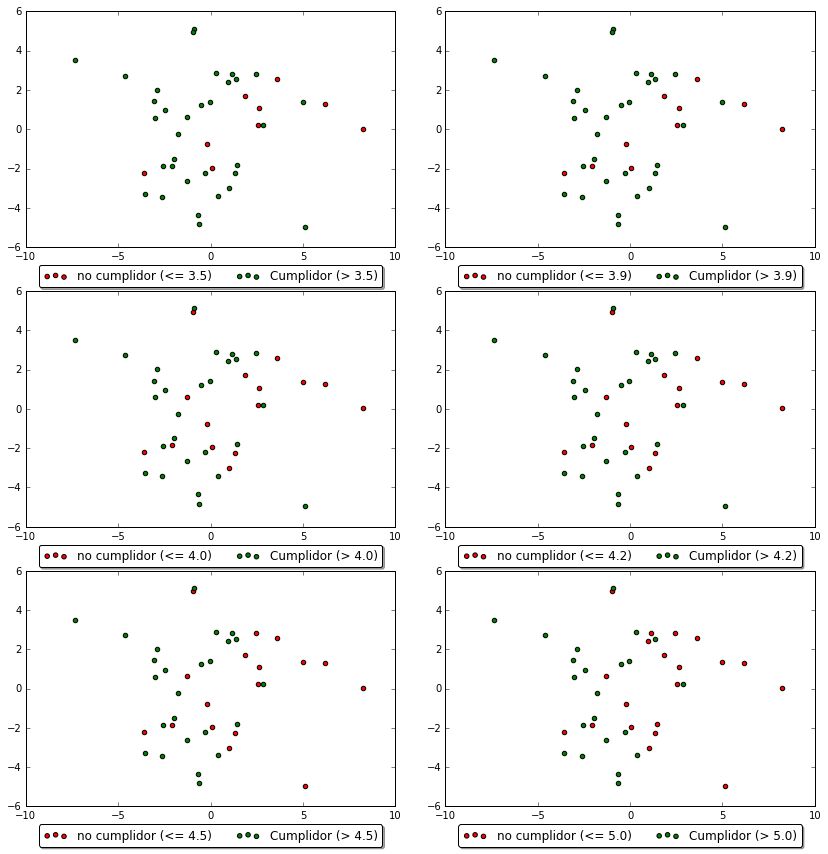

In [204]:
#Label differences

fig = plt.figure(figsize=(12,12))
for t,thr in enumerate(thrs):
    
    target_names = ["no cumplidor (<= {})".format(thr), "Cumplidor (> {})".format(thr)]
    for c in classes:
        ax = plt.subplot(round(len(thrs)/2.0),2,t+1)

        if c == 0:
            print "\n",c, target_names[c], np.sum(df_all_scaled.ix[:,-1] <= thr), \
                    df_all_scaled.shape, X_r.shape
            ax.scatter(X_r[np.where(df_all_scaled.ix[:,-1] <= thr)[0], 0],
                        X_r[np.where(df_all_scaled.ix[:,-1] <= thr)[0], 1], 
                        c=colors[c], label=target_names[c])
        else:
            print c, target_names[c], np.sum(df_all_scaled.ix[:,-1] > thr), \
                    df_all_scaled.shape, X_r.shape        
            ax.scatter(X_r[np.where(df_all_scaled.ix[:,-1] > thr)[0], 0],
                        X_r[np.where(df_all_scaled.ix[:,-1] > thr)[0], 1], 
                        c=colors[c], label=target_names[c])
        
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2)
            
plt.tight_layout(pad=2.5)
plt.show()

#### PCA on numerical data

0 HORAS_USO_MED_NOCHE_3 4.5 5.5 6.975 [ 0.  1.  2.] 12 19 11
1 MEDIA TAS_3 119.125 135.5 143.625 [ 0.  1.  2.] 11 20 11
2 MEDIA TAD_3 75.0 82.5 87.375 [ 0.  1.  2.] 12 19 11
3 EPWORTH_3 3.4 5.88 7.0 [ 0.  1.  2.] 12 21 9
4 VISUAL EUROQOL_3 70.0 73.3442307692 80.0 [ 0.  1.  2.] 18 17 7


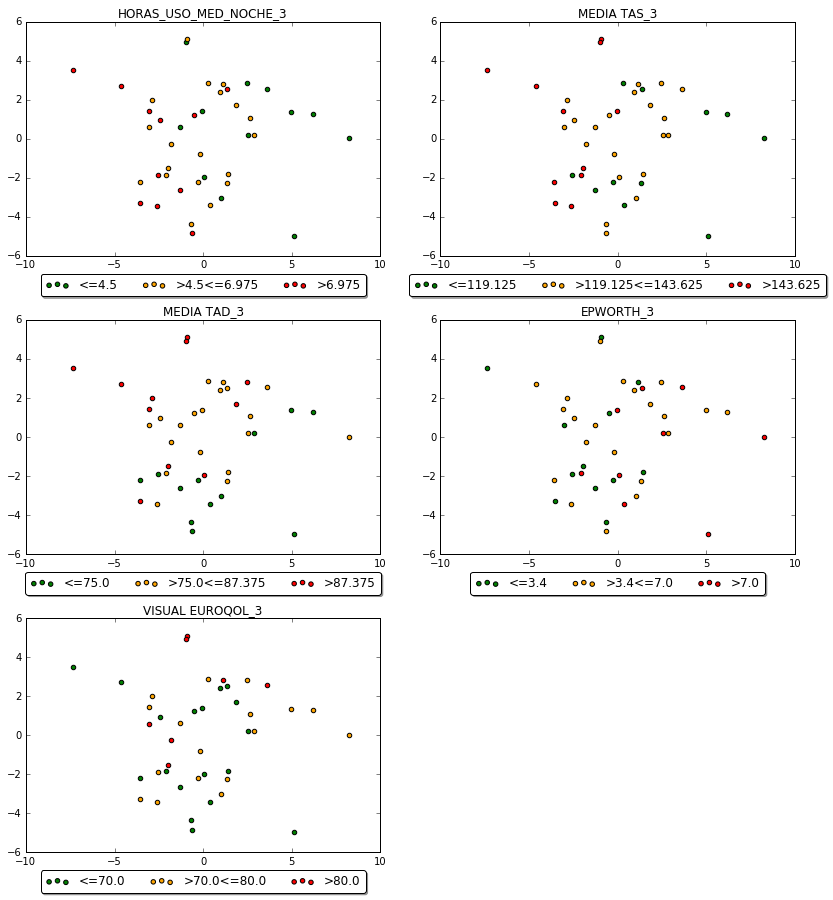

In [206]:
fig = plt.figure(1, figsize=(12, 50))
#plt.grid(visible=False)

k = 0
for i,c in enumerate(df_all_scaled.columns):
        
    if c in dfSigArr["column"].values: # dfNorm[dfNorm.variable == c][["categoric"]].values == "no":
        val_tmp = dfImputed[c].copy()
        values = dfImputed[c].copy()
        p25 = values.quantile(0.25)
        p50 = values.quantile(0.5)
        p75 = values.quantile(0.75)


        values[val_tmp<=p25] = 0
        values[np.logical_and(val_tmp>p25,val_tmp<=p75)] = 1
        values[val_tmp>p75] = 2
        strLabels = ["<=" + str(p25), ">"+str(p25)+"<="+str(p75), ">" + str(p75)]
        labels = np.unique(values)
        print k, c, p25, p50, p75, labels, np.sum(values==0), np.sum(values==1), np.sum(values==2)
        
        cs = ["green", "orange", "red"]
        ax = plt.subplot(12,2,k+1)
        for i,l in enumerate(labels):
                ax.scatter(X_r[np.where(values==l)[0], 0], X_r[np.where(values==l)[0], 1], label = strLabels[i], c=cs[i])
        ax.set_title(c)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=3)
        k += 1

        
plt.tight_layout(pad=3.5)
plt.show()

#### Clustering

In [207]:
from sklearn import metrics
from sklearn.cluster import KMeans

pca_dim = 15
best_k_stab = []

for i in range(50):

    best_k = -1
    best_score = -1
    for k in range(2,10,1):
        kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
        kmeans.fit(X_r[:,:pca_dim])
        X_pred = kmeans.predict(X_r[:,:pca_dim])
        score = metrics.silhouette_score(X_r[:,:2],X_pred,metric='euclidean',sample_size=X_r.shape[0])
        if best_score < score:
            best_score = score
            best_k = k
    print i, best_k, best_score
    best_k_stab.append([best_k, best_score])

0 2 0.380545182379
1 2 0.380545182379
2 2 0.380545182379
3 2 0.380545182379
4 2 0.380545182379
5 2 0.381021006637
6 2 0.380545182379
7 2 0.380545182379
8 2 0.380545182379
9 2 0.380545182379
10 2 0.380545182379
11 2 0.358378563827
12 2 0.380545182379
13 2 0.380545182379
14 2 0.381021006637
15 2 0.380545182379
16 2 0.380545182379
17 2 0.380545182379
18 2 0.380545182379
19 2 0.380545182379
20 2 0.380545182379
21 2 0.380545182379
22 2 0.380545182379
23 2 0.380545182379
24 2 0.380545182379
25 2 0.380545182379
26 2 0.380545182379
27 2 0.381021006637
28 2 0.380545182379
29 2 0.380545182379
30 2 0.380545182379
31 3 0.381798133463
32 2 0.380545182379
33 2 0.380545182379
34 2 0.380545182379
35 2 0.380545182379
36 2 0.380545182379
37 2 0.380545182379
38 2 0.381021006637
39 2 0.380545182379
40 2 0.380545182379
41 2 0.380545182379
42 2 0.380545182379
43 2 0.380545182379
44 2 0.380545182379
45 2 0.380545182379
46 2 0.380545182379
47 2 0.380545182379
48 2 0.369251258517
49 2 0.380545182379


In [208]:
df = pd.DataFrame(best_k_stab, columns = ["k", "score"])
df = df.groupby("k").count().reset_index().iloc[:,:2]
df.sort_values("score", ascending= False, inplace=True)

best_k =  df["k"].iloc[0]
print "Best # clusters:", best_k
df.head()

Best # clusters: 2


,k,score
0,2,49
1,3,1


2


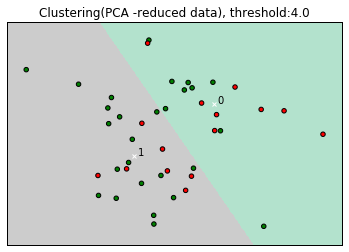

In [209]:
# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = X_r[:, 0].min() - 1, X_r[:, 0].max() + 1
y_min, y_max = X_r[:, 1].min() - 1, X_r[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model
print best_k

kmeans = KMeans(init='k-means++', n_clusters=best_k, n_init=100)
kmeans.fit(X_r[:,:2])
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Pastel2,
           aspect='auto', origin='lower')


# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=16, linewidths=1,
            color='w', zorder=10, label="")

for k,c in enumerate(range(centroids.shape[0])):
    plt.text(centroids[k,0]+.2, centroids[k,1],str(k))

plt.scatter(X_r[:, 0], X_r[:, 1], c=np.array(["g" if d > thrs[-4] else "r" for d in df_all_scaled.ix[:,-1].values]))
plt.legend()
plt.title('Clustering(PCA -reduced data), threshold:' + str(thrs[-4]))

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

plt.show()

#### K-means explanation

CPAP USAGE (CLUST-0):
[0.0, 6.5, 5.0, 7.0, 5.0, 4.0, 4.5, 3.3199999999999998, 6.5, 0.0, 5.5, 2.0800000000000001, 5.3200000000000003, 2.6000000000000001, 4.0, 4.5, 0.96999999999999997] 6 11 66.79
CPAP USAGE (CLUST-1):
[7.0, 7.5, 3.5, 6.5099999999999998, 6.5, 6.0, 8.0, 3.9300000000000002, 3.5, 7.0, 4.9900000000000002, 7.5, 4.0, 6.0, 7.5, 8.0, 7.0, 6.5, 5.5, 7.0, 3.7999999999999998, 2.1200000000000001, 7.5, 4.0, 5.5] 5 20 146.35


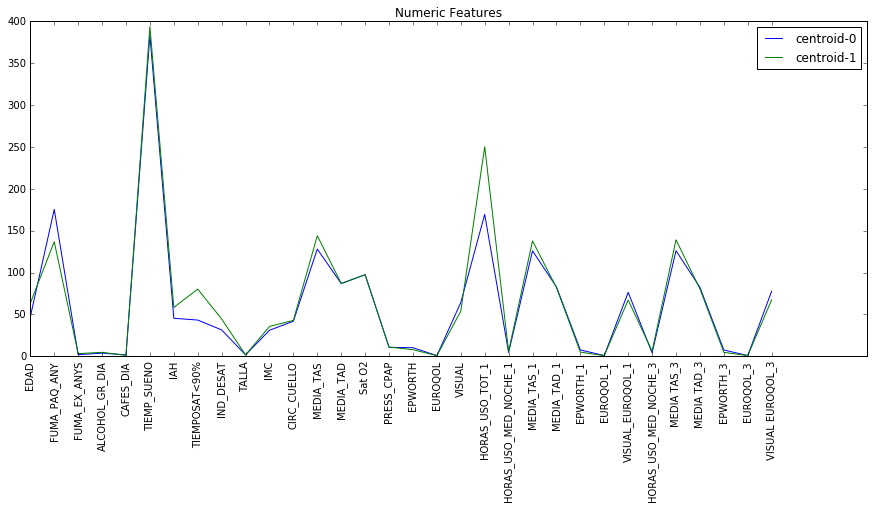

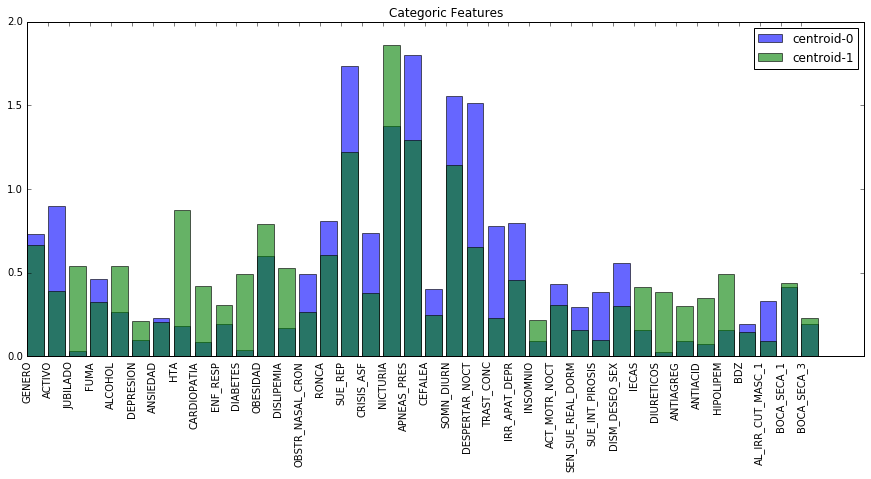

,0,1,diff[0-1]
GENERO,0.73,0.66,0.07
ACTIVO,0.90,0.39,0.51
JUBILADO,0.03,0.54,-0.51
EDAD,47.34,63.45,-16.10
FUMA,0.46,0.33,0.14
FUMA_PAQ_ANY,175.47,136.96,38.50
FUMA_EX_ANYS,1.97,3.19,-1.23
ALCOHOL,0.27,0.54,-0.27
ALCOHOL_GR_DIA,3.78,4.74,-0.96
CAFES_DIA,1.70,1.13,0.57


In [210]:
X_pred = kmeans.predict(X_r[:,:2])
grAllRedKm = np.hstack((df_all_scaled.iloc[:,:-1],X_pred.reshape(-1,1)))

sleep = [[],[]]
for i,k in enumerate(X_pred):
    sleep[k].append(df_all.iloc[i,-1])
    
print "CPAP USAGE (CLUST-0):\n", sleep[0], np.sum(np.array(sleep[0]) < 4), np.sum(np.array(sleep[0]) >= 4), np.sum(np.array(sleep[0]))
print "CPAP USAGE (CLUST-1):\n", sleep[1], np.sum(np.array(sleep[1]) < 4), np.sum(np.array(sleep[1]) >= 4), np.sum(np.array(sleep[1]))
    
#Get pca for 2 components
pca = PCA(n_components=2)
X_SCALED = df_all_scaled.ix[:,:-1].values
X_r = pca.fit(X_SCALED).transform(X_SCALED)

#Compute centroids
ctrPca = kmeans.cluster_centers_
ctrInvPca = [pca.inverse_transform(ctr.reshape(-1,2)) for ctr in ctrPca]
ctr = [scaler.inverse_transform(ctr) for ctr in ctrInvPca]
dfCtr = pd.DataFrame(np.array(ctr).reshape(2,-1), columns=df_all.columns[:-1])

#Plot categoric features
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
for i in range(dfCtr.shape[0]):
    ax.plot(range(dfCtr.loc[i,catCols==0].shape[0]), dfCtr.loc[i,catCols==0],label="centroid-"+str(i))

plt.xticks(range(dfCtr.loc[i,catCols==0].shape[0]),dfCtr.columns[catCols==0],rotation=90)
plt.title("Numeric Features")
plt.legend()
plt.show()

#Plot numeric table
plt.figure(figsize=(15,6))
ax = plt.subplot(1,1,1)
for i in range(dfCtr.shape[0]):
    ax.bar(range(dfCtr.loc[i,catCols==1].shape[0]), dfCtr.loc[i,catCols==1],label="centroid-"+str(i),alpha=0.6)

plt.xticks(range(dfCtr.loc[i,catCols==1].shape[0]),dfCtr.columns[catCols==1],rotation=90)
plt.title("Categoric Features")
plt.legend()
plt.show()

#Plot table
diff = (dfCtr.iloc[0,:].values - dfCtr.iloc[1,:].values).reshape(1,-1)
ctr = np.hstack((dfCtr.T.values, diff.T))#, stats.ttest_ind(dfCtr.iloc[:,0], dfCtr.iloc[:,1])[1])
dfCtr = pd.DataFrame(ctr, columns= ["0","1","diff[0-1]"], index = dfCtr.T.index)
dfCtr

#### Outliers analysis

Looking for users with a value in its columns that is an outlier
We need user code!!

/home/aegle/miniconda2/envs/myosa/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix


0.217669776756 10.0440460753 10.261715852
10.5882205172 9.71754141016

Ouliers min ratio: 10.5882205172 9.71754141016
Num outliers detected: 1
Num outliers detected: 0
[('MY56', 10.195479594440384), ('MY12', 9.946753217478614), ('MY45', 10.100533470728701), ('MY55', 10.904859123682849), ('MY15', 10.339691365854062), ('MY20', 9.8458828333746791), ('MY24', 10.487493988722017), ('MY28', 10.096171455827404), ('MY51', 9.9891043771567958), ('MY09', 9.8432918364927247), ('MY02', 10.287578783418342), ('MY59', 10.168892087643261), ('MY29', 10.454917464240971), ('MY21', 10.120122472138492), ('MY37', 10.288569287055436), ('MY34', 10.280041120075698), ('MY36', 10.166297025902917), ('MY27', 10.114887514566057), ('MY44', 10.07432466483565), ('MY14', 10.148080169524951), ('MY42', 10.069327177867772), ('MY41', 10.194550154258479), ('MY50', 10.121147882088676), ('MY18', 10.06559005071011), ('MY01', 10.16587597696142), ('MY57', 10.043977242590415), ('MY46', 10.112140075266584), ('MY06', 9.99921421243202

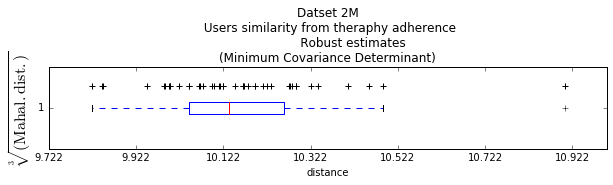

In [211]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope

dfImputed_out = dfImputed.values
#dfImputed_out = df_all_scaled.ix[:,:-1]
scaler_norm = preprocessing.Normalizer(norm='l2').fit(dfImputed_out[:,:-1])
df_all_norm = scaler_norm.transform(dfImputed_out[:,:-1]).astype(float)

df_all_norm = pd.DataFrame(
    data = np.hstack((df_all_norm, dfImputed_out[:,-1].reshape((dfImputed_out.shape[0],1)))), 
    columns = df_all.columns[:-1])

X_SCALED = df_all_norm.ix[:,:-1].values
#X_SCALED = df_all.ix[:,:-1].values
#X_SCALED = df_all_scaled.ix[:,:-1].values

robust_cov_all = EmpiricalCovariance().fit(X_SCALED[:,:])
robust_mahal_all = robust_cov_all.mahalanobis(X_SCALED[:,:] - robust_cov_all.location_) ** (0.33)

#BoxPlot data
fig = plt.figure(figsize=(10,5))
sf = plt.subplot(3, 1, 1)
bx = sf.boxplot(robust_mahal_all,vert=0)

#ALT:1
#outlierRatioRob_all =  np.min(bx["fliers"][0].get_data()[0])

#ALT:2
rm = pd.DataFrame(robust_mahal_all, columns=["value"])

iqr = float(rm["value"].quantile(0.75)) - float(rm["value"].quantile(0.25))
outlierRatioRob_all_1 = rm["value"].quantile(0.75) + (1.5 * iqr)
outlierRatioRob_all_2 = rm["value"].quantile(0.25) - (1.5 * iqr)
print iqr, rm["value"].quantile(0.25), rm["value"].quantile(0.75)

#threshold = 0.99
#outlierRatioRob_all_1 = rm.quantile(threshold).values[0]
#outlierRatioRob_all_2 = rm.quantile(1-threshold).values[0]

print outlierRatioRob_all_1, outlierRatioRob_all_2
print

sf.plot(robust_mahal_all, 1.26 * np.ones(len(robust_mahal_all)),'+k', markeredgewidth=1)
sf.set_xlabel('distance')
sf.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
sf.set_title("Datset {}M\n Users similarity from theraphy adherence\n \
            Robust estimates\n(Minimum Covariance Determinant)".format(index))
sf.set_xticks(np.arange(min(robust_mahal_all)-0.1, max(robust_mahal_all)+0.1, 0.2))

print "Ouliers min ratio:", outlierRatioRob_all_1, outlierRatioRob_all_2
print "Num outliers detected:", len(X_SCALED[robust_mahal_all > outlierRatioRob_all_1, 0])
print "Num outliers detected:", len(X_SCALED[robust_mahal_all < outlierRatioRob_all_2, 0])
print [(codes[r],robust_mahal_all[r]) for r in range(len(robust_mahal_all))]

patients_out = codes[robust_mahal_all > outlierRatioRob_all_1]
print "Patients outliers above: {}".format(patients_out)

patients_out = codes[robust_mahal_all < outlierRatioRob_all_2]
print "Patients outliers below: {}".format(patients_out)


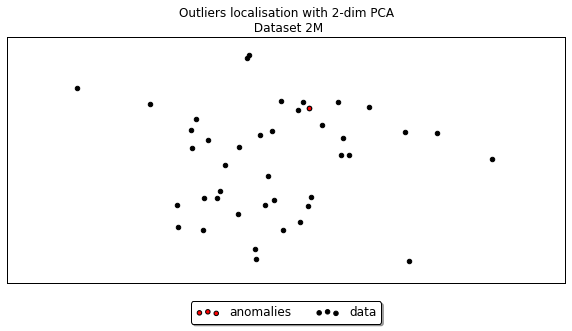

In [212]:
# plot and show data set
fig = plt.figure(figsize=(10,15))
subfig1 = plt.subplot(3, 1, 3)

#Show inliers vs outliers
inlier_plot = subfig1.scatter(X_r[:, 0], X_r[:, 1], c='black', label='inliers')
outlier_plot = subfig1.scatter(X_r[robust_mahal_all > outlierRatioRob_all_1, 0], 
                               X_r[robust_mahal_all > outlierRatioRob_all_1, 1],
                               c='red', label='outliers')
outlier_plot = subfig1.scatter(X_r[robust_mahal_all < outlierRatioRob_all_2, 0], 
                               X_r[robust_mahal_all < outlierRatioRob_all_2, 1],
                               c='red', label='outliers')

subfig1.set_xlim(subfig1.get_xlim()[0], 11.)
subfig1.set_title(("Outliers localisation with 2-dim PCA\n Dataset {}M").format(index))

subfig1.legend([outlier_plot, inlier_plot],\
               ['anomalies','data'],\
               loc='upper center', bbox_to_anchor=(0.5, -0.05),
               fancybox=True, shadow=True, ncol=5)
plt.xticks(())
plt.yticks(())

plt.show()

### 3. Visualisation

In [215]:
"""scaler = preprocessing.StandardScaler().fit(dfImputed.ix[:,:-1])
df_all_scaled = scaler.transform(dfImputed.ix[:,:-1])
df_all_scaled = pd.DataFrame(
    data = np.hstack((df_all_scaled, dfImputed.ix[:,-1].values.reshape((dfImputed.shape[0],1)))), 
    columns = dfImputed.columns)

print df_all_scaled.describe()"""

'scaler = preprocessing.StandardScaler().fit(dfImputed.ix[:,:-1])\ndf_all_scaled = scaler.transform(dfImputed.ix[:,:-1])\ndf_all_scaled = pd.DataFrame(\n    data = np.hstack((df_all_scaled, dfImputed.ix[:,-1].values.reshape((dfImputed.shape[0],1)))), \n    columns = dfImputed.columns)\n\nprint df_all_scaled.describe()'

#### Visualize all data x columns

(27, 71)
(15, 71)


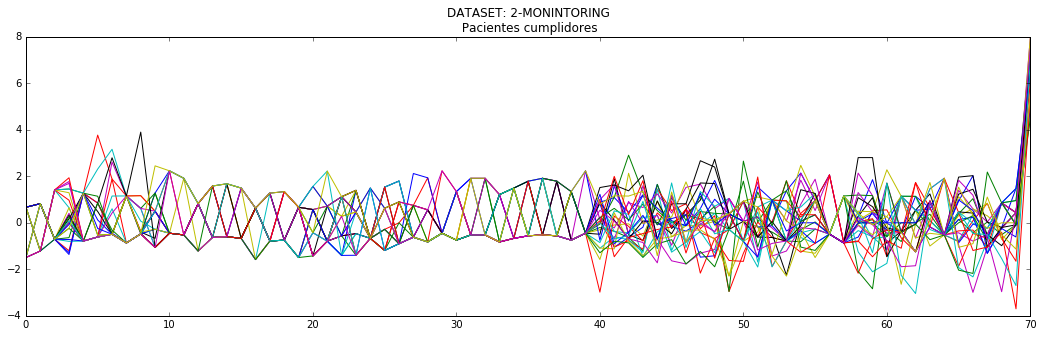

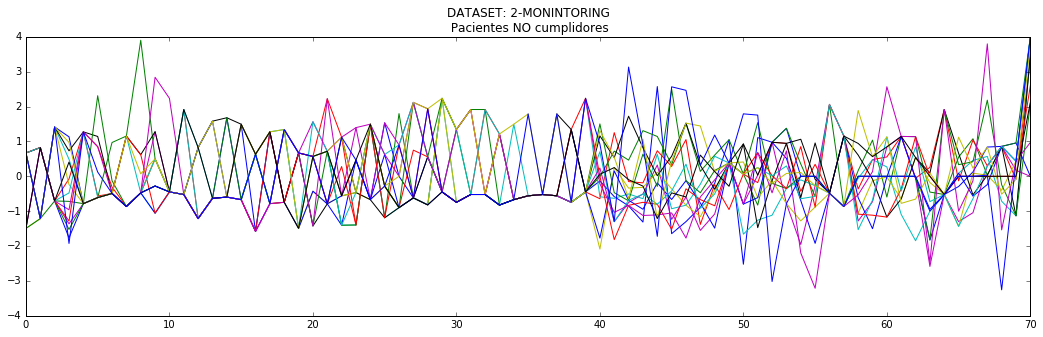

In [218]:
#Visualize row data

data = df_all_scaled[df_all_scaled['LABEL'] > thrs[-4]].values
data = data.astype(float)
print data.shape


plt.figure(figsize=(18,5))
plt.plot(data[:,:].T)
plt.title("DATASET: {}-MONINTORING\n Pacientes cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

data = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].values
data = data.astype(float)

print data.shape
plt.figure(figsize=(18,5))
plt.plot(data[:,:].T)
plt.title("DATASET: {}-MONINTORING\n Pacientes NO cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

#### Visualize mean + std data

(27, 70)


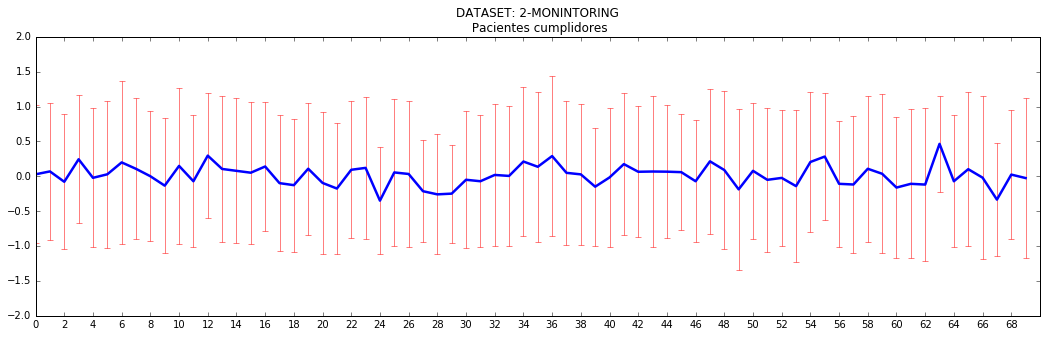

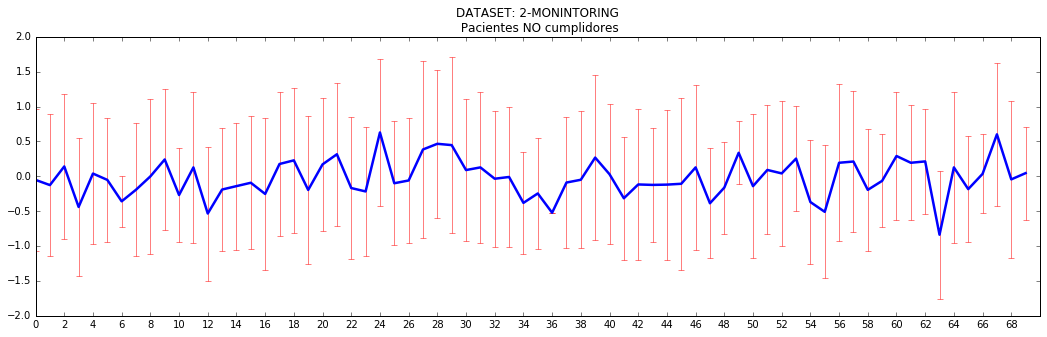

In [223]:
data_tmp = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]].values[:,:-1]
data = data_tmp.astype(float)
print data.shape

plt.figure(figsize=(18,5))
plt.subplot(1,1,1)
plt.errorbar(x=range(data.shape[1]),
             y=np.mean(data, axis=0),
             yerr=np.std(data, axis=0), 
             ecolor='r', capthick=0.5, elinewidth = 0.5, linewidth=2.5
             )
pts = range(data.shape[1])
plt.xticks(np.arange(min(pts), max(pts)+1, 2.0))
plt.title("DATASET: {}-MONINTORING\n Pacientes cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)
plt.ylim((-2,2))

data_tmp = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].values[:,:-1]
data = data_tmp.astype(float)

plt.figure(figsize=(18,5))
plt.errorbar(x=range(data.shape[1]),
             y=np.mean(data, axis=0),
             yerr=np.std(data, axis=0),
             ecolor='r', capthick=0.5, elinewidth = 0.5, linewidth=2.5
             )
pts = range(data.shape[1])
plt.xticks(np.arange(min(pts), max(pts)+1, 2.0))
plt.title("DATASET: {}-MONINTORING\n Pacientes NO cumplidores".format(index))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=10)

In [220]:
df_all_scaled[df_all_scaled['LABEL']==0][df_all_scaled.columns[:-1]]

,GENERO,ACTIVO,JUBILADO,EDAD,FUMA,FUMA_PAQ_ANY,FUMA_EX_ANYS,ALCOHOL,ALCOHOL_GR_DIA,CAFES_DIA,...,EPWORTH_1,EUROQOL_1,VISUAL_EUROQOL_1,HORAS_USO_MED_NOCHE_3,BOCA_SECA_3,MEDIA TAS_3,MEDIA TAD_3,EPWORTH_3,EUROQOL_3,VISUAL EUROQOL_3
0,0.67,0.82,-0.71,-1.76,-0.78,-0.61,-0.49,-0.87,-0.48,-0.28,...,0.00,0.00,0.00,-1.83,-0.52,-0.29,0.13,0.84,0.86,0.96
15,-1.49,0.82,-0.71,-1.36,-0.78,-0.61,-0.49,-0.87,-0.48,1.28,...,0.84,1.14,-0.06,-2.58,-0.52,-1.30,-1.04,0.30,0.86,0.17


In [324]:
target_names = ['No compliant', 'Compliant']
classLbls = ['No cumplidor', 'Cumplidor']
classes = [0,1]

(15, 70)
(27, 70)


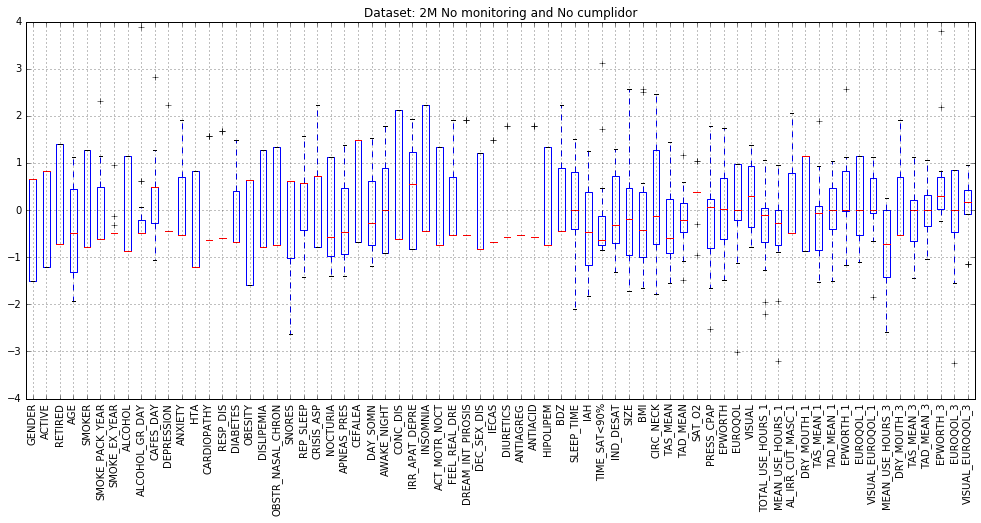

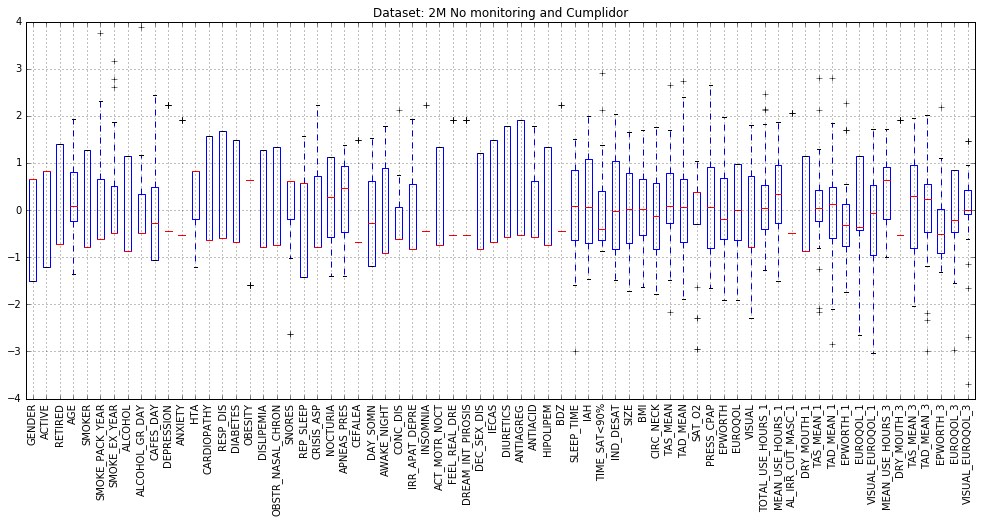

In [325]:
figsize = (17, 6.75)

codes_type = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]].index
df = df_all_scaled[df_all_scaled['LABEL']<= thrs[-4]][df_all_scaled.columns[:-1]]
print df.shape
fig, ax = plt.subplots(figsize=figsize)
df.astype(float).boxplot(rot=90)
ax.set_title("Dataset: {}M No monitoring and {}".format(index, classLbls[0]))

codes_type = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]].index
df = df_all_scaled[df_all_scaled['LABEL']> thrs[-4]][df_all_scaled.columns[:-1]]
print df.shape
fig, ax = plt.subplots(figsize=figsize)
df.astype(float).boxplot(rot=90)
ax.set_title("Dataset: {}M No monitoring and {}".format(index, classLbls[1]))